This is my 2nd attempt to solve the Spaceship Titanic Data science competition on the data science platform Kaggle.

# Preliminary: imports and load the data

In [121]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import os
sns.set_theme(style="darkgrid")

In [122]:
# variable to determine whether the notebook is running on Collab or not
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

Please make sure to download the data and have it in the same directory as this notebook when running it.

In [123]:
import os
from zipfile import ZipFile

DOWNLOAD_DIR = "sample_data" if IN_COLAB else os.getcwd() 
file_name = "spaceship-titanic.zip"
file_name_no_zip = "spaceship-titanic"
loc = os.path.join(DOWNLOAD_DIR, file_name)
# opening the zip file in READ mode

if not os.path.isdir(os.path.join(DOWNLOAD_DIR, file_name_no_zip)):
    with ZipFile(loc, 'r') as zip_ref:
        zip_ref.extractall()
        print('Done!')

Done!


In [124]:
train_loc = os.path.join(os.getcwd(), "train.csv")
test_loc = os.path.join(os.getcwd(), "test.csv")

# these represent a backup of the original data for later use
train_data = pd.read_csv(train_loc)
test_data = pd.read_csv(test_loc)

df = pd.read_csv(train_loc)
df_test = pd.read_csv(test_loc)

# Helper functions
in this subsection I write a number of functions to frequently use later.

In [125]:
# a function to delete columnsfrom both the train and test datasets
def drop_cols(cols, df_train: pd.DataFrame, df_test: pd.DataFrame):
    if isinstance(cols, str):
        df1 = df_train.drop(cols, axis=1)
        df2 = df_test.drop(cols, axis=1)
    else:
        df1 = df_train.drop(columns=cols)
        df2 = df_test.drop(columns=cols)
    return df1, df2

In [126]:
def new_col_names(old_new_names, df_train ,df_test):
    try:    
        df = df_train.rename(columns=old_new_names)
        df_test = df_test.rename(columns=old_new_names)
        return df, df_test
    except:
        df_no_col = [col for col in old_new_names.keys if col not in df.columns]
        df_test_no_col = [col for col in old_new_names.keys if col not in df_test.columns]
        print("{cols} are not in the {dataf}".format(df_no_col, "training dataset"))
        print("{cols} are not in the {dataf}".format(df_test_no_col, "test dataset"))


In [127]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encoder(df: pd.DataFrame, features_names: list=None):
    # select all categorical features if none of them were specified
    if features_names is None:
        features_names = df.select_dtypes(include=['object']).columns.tolist()
    # define the encoder
    
    ohe = OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False, dtype=np.int64)
    for f in features_names:        
        try:
            unique_values = np.unique(df[f])
        except:
            unique_values = list(df[f].value_counts().index)
        
        # if there is only one unique value in the column, then this column is to be dropped
        if len(unique_values) <= 1 :
            break
        # the names for the  newly-created features
        new_names = [f'{f}_{u}' for u in unique_values[1:]]
        new_values = ohe.fit_transform(df[[f]])
        print(ohe.categories_)
        df[new_names] = new_values
    
    return df


In [128]:
! pip install empiricaldist

In [129]:
from empiricaldist import Cdf

def display_cdf(data: pd.DataFrame, num_feat: str, cat_feat: str, feat_values: list=None):
    if feat_values is None:
        # extract the unique values in the passed feature
        feat_values = list(data[cat_feat].value_counts().index)
    
    # iterate through the different values of feat_values 
    for v in feat_values:
        d = data[data[cat_feat] == v][num_feat]
        data_cdf = Cdf.from_seq(d)
        data_cdf.plot(label=f'{cat_feat} == {v}')

    plt.legend()
    plt.xlabel(f'{num_feat}')
    plt.ylabel(f'cdf of {num_feat}')
    plt.show()   
                

In [130]:
# Create table for missing data analysis
def draw_missing_data_table(df):
    # find the number of nans in each column
    total = df.isnull().sum().sort_values(ascending=False)
    # calculate the percentage of missing values in each column
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    # convert the results into a dataframe
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

In [131]:
# let' define a function that applies a function to either 
# the whole dataframe or certain columns on the dataframe

def apply_functions(df_train, df_val, funcs, col_names=None):
    # either have one function passed that should be applied to the whole dataframe
    # or have an equal number of columns and functions where each funtion will be applied to the corresponding column
    all_data = callable(funcs) and col_names is None
    col_funcs = True
    #  if the funcs argument is indeed a function, then the code below will raise an error 
    try:
        col_funcs = (all([callable(f) for f in funcs]) and len(funcs) == len(col_names))
    except:
        col_funcs = False
    
    assert all_data or col_funcs
        
    if col_names is None: # if the function is to be applied on the whole dataframe
        df = df_train.apply(funcs, axis=1)
        df_test = df_val.apply(funcs, axis=1)
    else:
        df = df_train.copy()
        df_test = df_val.copy()

        for col, f in zip(col_names, funcs):
            df[col] = df[col].apply(f)
            df_test[col] = df_test[col].apply(f)
            
    return df, df_test

In [132]:
def get_col_types(df: pd.DataFrame, nunique_as_discrete=20):
    # select all numerical features 
    num_cols = set(list(df.select_dtypes(np.number).columns))
    # any feature that is non-numerical is selected as categorical
    cat_cols = set([c for c in df.columns if c not in num_cols])
    
    # let's further filter the numerical features: those with a small number of unique values are considered categorical
    discrete_num_cols = [col for col in num_cols if len(df.value_counts(col)) <= nunique_as_discrete]
    # add them to the categorical features
    cat_cols.update(discrete_num_cols)
    # update the numerical features
    num_cols = num_cols.difference(cat_cols)
    return num_cols, cat_cols


In [133]:
def display_histogram(data, num_feat, cat_feat, figsize=None):
    if figsize is None:
        figsize = (10, 10)
    plt.figure(figsize=figsize)
    cat_unique = list(data.value_counts(cat_feat).index)
    for v in cat_unique:
        plt.hist(data[data[cat_feat] == v][num_feat], bins=100, alpha=0.5, label=f"{cat_feat} == {v}")

    plt.xlabel(f"{num_feat}", size=14)
    plt.ylabel("count", size=14)
    plt.title(f"{num_feat} distribution for different values of {cat_feat}")
    plt.legend(loc='upper right')
    plt.show()

def display_cat_plot(data: pd.DataFrame, num_feat, cat_feat, num_cat='box'):
    g = sns.catplot(data=data, x=num_feat, y=cat_feat, kind=num_cat, orient='h')
    g.fig.suptitle(f"distribution of {num_feat} for different values of {cat_feat}")
    g.set(xlabel=f"{num_feat}", ylabel=f"{cat_feat}")
    plt.show()

def visualize_num_cat(data: pd.DataFrame, num_feat: str, cat_feat: str, num_cat='box', nunique_as_discrete=20):
        valid_num_cat = ['cdf', 'hist', 'box', 'violin','boxen']
        num_cat = num_cat.lower()
        
        # make sure to have a meaningful plot
        if num_feat == cat_feat or len(data.value_counts(cat_feat)) > nunique_as_discrete: 
            return
        try:
            assert num_cat in valid_num_cat
            # only display categorical features with reasonable number of categories / unique values
            if num_cat == 'cdf':
                display_cdf(data, num_feat=num_feat, cat_feat=cat_feat)
            elif num_cat == 'hist':
                display_histogram(data, num_feat=num_feat, cat_feat=cat_feat)
            else:
                display_cat_plot(data=data, num_feat=num_feat, cat_feat=cat_feat, num_cat=num_cat)
        except (KeyError, AssertionError):
            print("PLEASE MAKE SURE TO PASS FEATURES THAT BELONG TO THE DATAFRAME PASSED, AND TO CHOOSE A VALID num_cat argument")
            print(f"THE LATTER CAN HAVE THE FOLLOWING VALUES {valid_num_cat}")    

def visualize_cat_cat(data: pd.DataFrame, cat1: str, cat2: str, nunique_as_discrete=20, cat_cat='count'):
        # make sure to have a meaningful plot
        if cat1 == cat2 or len(data.value_counts(cat1)) > nunique_as_discrete or len(data.value_counts(cat2)) > nunique_as_discrete: 
            return
        
        # the hue parameter should be assigned the feature with the smaller number of possible values
        feats = [cat1, cat2]
        feats = sorted(feats, key=lambda x: len(data.value_counts(x)))
        hue_feat, x_feat = feats
        try:
            sns.catplot(kind=cat_cat, data=data, x=x_feat, hue=hue_feat)
            plt.xticks(rotation=45)
            plt.show()
        except (AssertionError, KeyError):
            print("PLEASE MAKE SURE TO PASS FEATURES THAT BELONG TO THE DATAFRAME PASSED, AND TO CHOOSE A VALID cat_cat argument")
            print(f"THE LATTER CAN HAVE THE FOLLOWING VALUES {['count', 'bar']}")    
        
def visualize_num_num(data: pd.DataFrame, num1: str, num2: str, num_num='scatter'):
        # make sure to have a meaningful plot
        if num1 == num2: 
            return
        
        try:
            g = sns.relplot(data=data, x=num1, y=num2, kind=num_num)
            g.fig.suptitle(f"The bivaritate distribution of {num1} and {num2}")
            g.set(xlabel=f"{num1}", ylabel=f"{num2}")
            plt.show()
        except (AssertionError, KeyError):
            print("PLEASE MAKE SURE TO PASS FEATURES THAT BELONG TO THE DATAFRAME PASSED, AND TO CHOOSE A VALID cat_cat argument")
            print(f"THE LATTER CAN HAVE THE FOLLOWING VALUES {['scatter']}")    

def visualize_interaction(data:pd.DataFrame, feature, use_cols=None, nunique_as_discrete=20, num_cat='box', num_num='scatter', cat_cat='count', num_feats=None, cat_feats=None):
    try:
        data[feature]
    except (KeyError):
        print(f"{feature} is not part of the dataframe's features")
        return 

    if use_cols is None:
        use_cols = data.columns

    if isinstance(use_cols, str):
        use_cols = [use_cols] 

    # filter the use_cols to keep only those belonging to the passed dataframe
    use_cols = [column for column in use_cols if column in set(data.columns)]

    if num_feats is None or cat_feats is None:
        # extract the numerical and categorical features, if they are not specified by the user-call
        num_feats, cat_feats = get_col_types(data)

    # # filter use_cols to keep only those featurs with a reasonable number of unique values (that wouldn't crush matplotlib)
    # for cf in set(use_cols).union(set([feature])):
    #     u = len(df.value_counts(cf))
    #     if u > nunique_as_discrete:
    #         print(f"feature {cf} has {u} unique values")

    # consider the case where the passed feat is indeed categorical:
    if feature in cat_feats:
        # iterate through all the columns in the dataset
        for col in use_cols:
            if col in num_feats: 
                visualize_num_cat(data=data, num_feat=col, cat_feat=feature, num_cat=num_cat, nunique_as_discrete=nunique_as_discrete)
            elif col in cat_feats:
                visualize_cat_cat(data=data, cat1=col, cat2=feature, cat_cat=cat_cat, nunique_as_discrete=nunique_as_discrete)
    
    elif feature in num_feats:
        for col in use_cols:
            if col in num_feats:
                visualize_num_num(data=data, num1=col, num2=feature)
            elif col in cat_feats:
                visualize_num_cat(data=data, num_feat=feature, cat_feat=col, num_cat=num_cat, nunique_as_discrete=nunique_as_discrete)        


In [134]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Validation score")

    plt.legend(loc="best")
    return plt

In [135]:
# for linux
! wget https://raw.githubusercontent.com/ayhem18/My_Kaggle_Repo/space_titanic/Competitions/SpaceshipTitanic/classifiers.py

# for windows
! curl.exe -o classifiers.py https://raw.githubusercontent.com/ayhem18/My_Kaggle_Repo/space_titanic/Competitions/SpaceshipTitanic/classifiers.py

'wget' is not recognized as an internal or external command,
operable program or batch file.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  3806  100  3806    0     0   8738      0 --:--:-- --:--:-- --:--:--  8769


In [136]:
from classifiers import tune_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

def classification_model(basic_estimator, estimator_name, grid, X, y):
    tuned_model = tune_model(basic_estimator, grid, X, y) 
    t1 = f"{estimator_name}: learning curve 1"
    CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)
    plot_learning_curve(tuned_model, t1, X, y,cv=10)
    print(f"The average accuracy of cross validation: {cross_val_score(tuned_model, X, y, scoring='accuracy', cv=CV).mean()}") 
    return tuned_model

In [137]:
def create_submission(estimator, X_train, y, X_test, estimator_name):
    estimator.fit(X_train, y)
    y_pred = pd.DataFrame(data=estimator.predict(X_test), columns=['Transported'])
    y_pred['PassengerId'] = test_data['PassengerId']
    y_pred['Transported'] = y_pred['Transported'].astype(bool)
    y_pred.set_index("PassengerId", inplace=True)
    y_pred.to_csv(os.path.join(os.getcwd(), f"{estimator_name} submission.csv")) 
    return y_pred
    

# MvP
In this section, I will try to build a basic, minimal machine learning pipeline to estimate the baseline performance and later proceed to enrich the data.

In [138]:
df.head()
# let's first seperate the predictors from the label
# rename the label column to 'y'
df = df.rename(columns={"Transported":"y"})
df['y'] = df['y'].astype(int)
y = df['y']

df, df_test = drop_cols("PassengerId", df, df_test)

df, df_test = new_col_names(str.lower, df, df_test)

new_names = {"foodcourt":"food", "shoppingmall": "mall", "roomservice": "room",
            "homeplanet":"home", "destination": "des", "vrdeck":"deck", "cryosleep":"sleep"}

df, df_test = new_col_names(new_names, df, df_test)
# the names associated with home and des features are lengthy 
# and unncessarily complex, each will be mapped to a single letter for easier  manipulation
des_dict = {"TRAPPIST-1e":"T", "PSO J318.5-22":"P", "55 Cancri e": "C"}
home_dict = {"Europa": "Eu", "Earth": "Ea", "Mars": "Ma"}

df, df_test = apply_functions(df, df_test, funcs=[des_dict.get, home_dict.get], col_names=['des', 'home'])

df_org = df.copy()
df_test_org = df_test.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   home    8492 non-null   object 
 1   sleep   8476 non-null   object 
 2   cabin   8494 non-null   object 
 3   des     8511 non-null   object 
 4   age     8514 non-null   float64
 5   vip     8490 non-null   object 
 6   room    8512 non-null   float64
 7   food    8510 non-null   float64
 8   mall    8485 non-null   float64
 9   spa     8510 non-null   float64
 10  deck    8505 non-null   float64
 11  name    8493 non-null   object 
 12  y       8693 non-null   int32  
dtypes: float64(6), int32(1), object(6)
memory usage: 849.1+ KB


In [139]:
# we can see we have a couple of missing values at each column. Nevertheless with very small portions.
# It might be useful to imput them accordingly.
# let's see how many rows have at least one nan  value 
print(df.shape)
df_non_nan = df.dropna()
df_non_nan.shape
# losing more than 2000 rows is indeed not a good idea. Let's try to impute the values

(8693, 13)


(6606, 13)

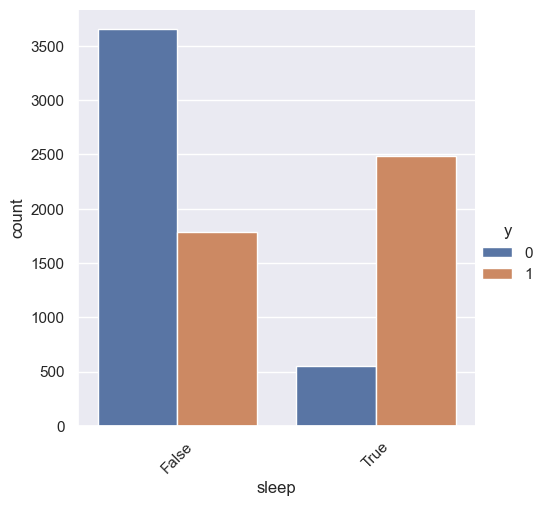

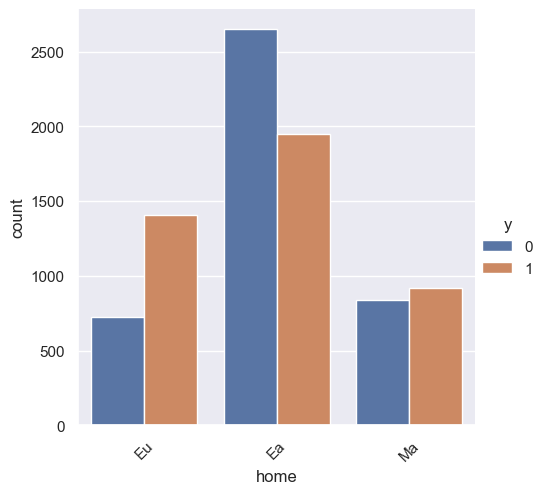

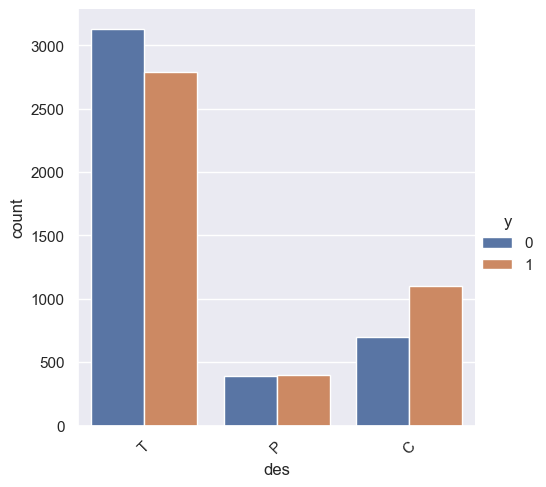

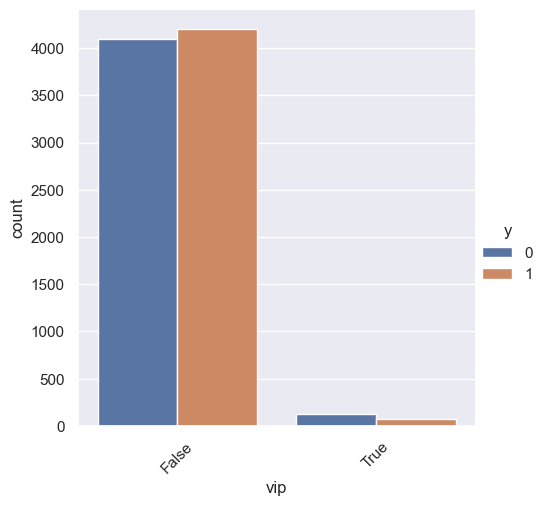

In [140]:
# let's try to understand how the different columns behave in general
num_cols, cat_cols = get_col_types(df)
for c in cat_cols:
    visualize_interaction(df, feature=c, use_cols=['y'])

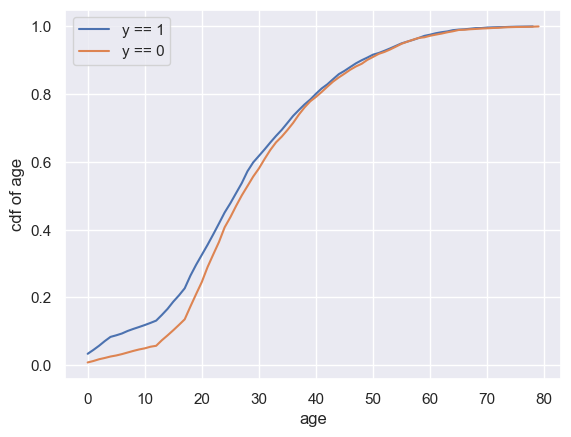

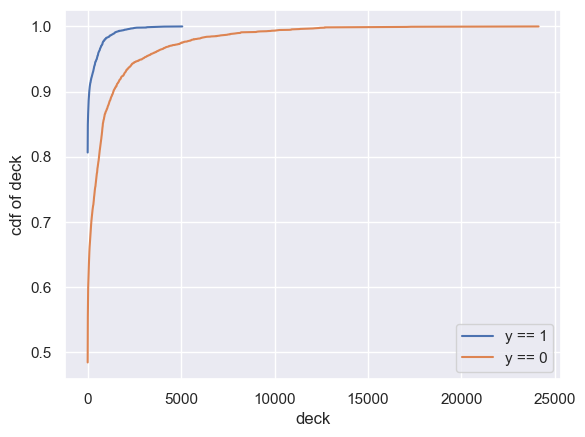

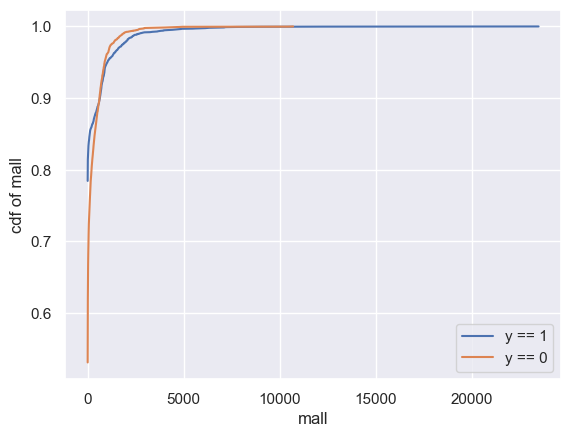

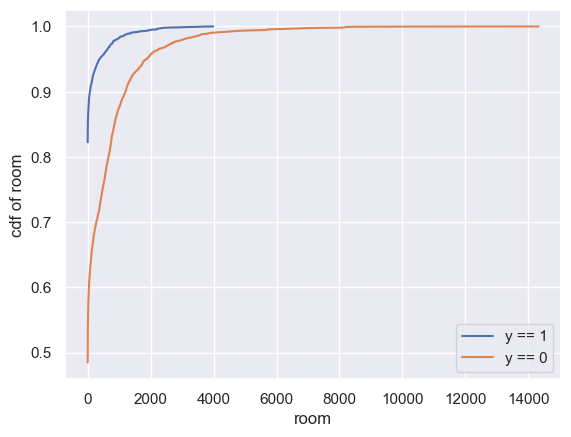

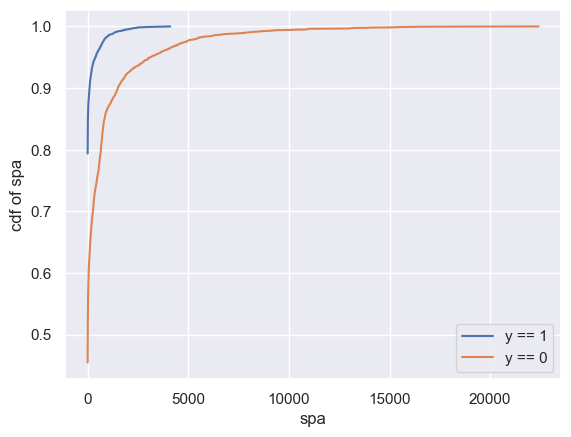

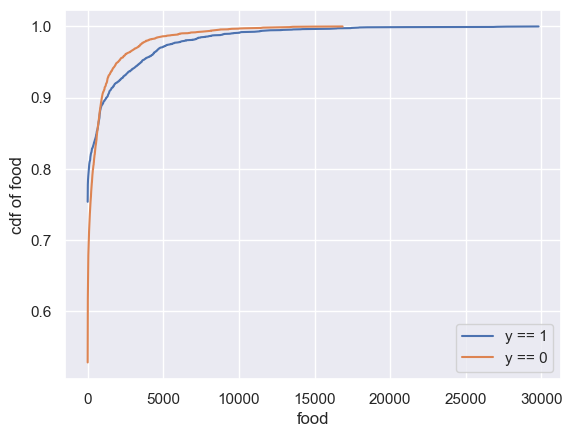

In [141]:
# let's try to understand how the different column behaves in general
for num in num_cols:
    visualize_num_cat(data=df, num_feat=num, cat_feat='y', num_cat="cdf")

Remarks:
* for all services except food, transported passengers spend less than non-transported ones 
* among the categorial features, the most informative feature seems to be CyroSleep. Sleeping passengers are likely to be teleported 
* VIP is not really that informative, as for both VIP and non-VIP, the passengers are almost equally distributed 
* destination and homePlanet as they are currently might not be really informative
* maybe some insight could be extracted from cabin and name: at the moment, they will be dropped


In [142]:
# let's drop the name and cabin features
df, df_test = drop_cols(['name', 'cabin'], df, df_test)

In [143]:
# let's consider the distributions of numerical columns
print(df.describe()) 

               age          room          food          mall           spa  \
count  8514.000000   8512.000000   8510.000000   8485.000000   8510.000000   
mean     28.827930    224.687617    458.077203    173.729169    311.138778   
std      14.489021    666.717663   1611.489240    604.696458   1136.705535   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      27.000000      0.000000      0.000000      0.000000      0.000000   
75%      38.000000     47.000000     76.000000     27.000000     59.000000   
max      79.000000  14327.000000  29813.000000  23492.000000  22408.000000   

               deck            y  
count   8505.000000  8693.000000  
mean     304.854791     0.503624  
std     1145.717189     0.500016  
min        0.000000     0.000000  
25%        0.000000     0.000000  
50%        0.000000     1.000000  
75%       46.000000     1.000000  
max    24133.0000

it is easy to see that the maximum values for each of the services in the Titanic SpaceShip are extravagent to say the least.
This should be investigated further.

In [144]:
# let's try to understand the percentage of missing values at each column
draw_missing_data_table(df)

,Total,Percent
sleep,217,0.024963
mall,208,0.023927
vip,203,0.023352
home,201,0.023122
deck,188,0.021627
food,183,0.021051
spa,183,0.021051
des,182,0.020936
room,181,0.020821
age,179,0.020591


only few missing values at each column, using "mean" or "median" imputing does not seem like a very bad idea for numerical columns
as for cyrosleep and vip, it might be worth veryfing a certain assumption
1. people in cyrosleep do not spend money at all: 
2. vip: spend significantly more than the rest of the passengers

In [145]:
# first let's add a total_spending column where it calculates the sum of money spent on different services

spending_cols = ['deck','room','food','spa', 'mall']
def total_spent(row):
    spending_cols = ['deck','room','food','spa', 'mall']
    row['total'] = row[spending_cols].sum()
    return row
df, df_test = apply_functions(df, df_test, total_spent)

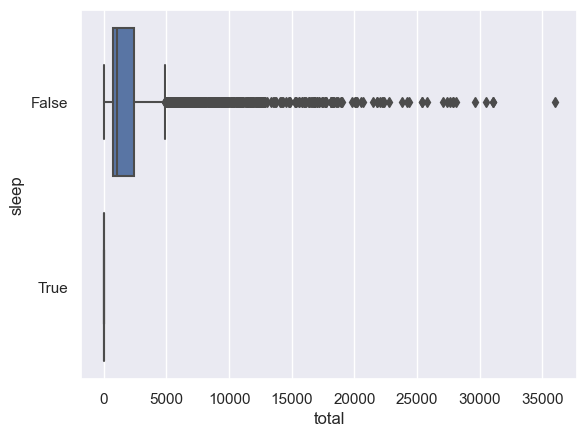

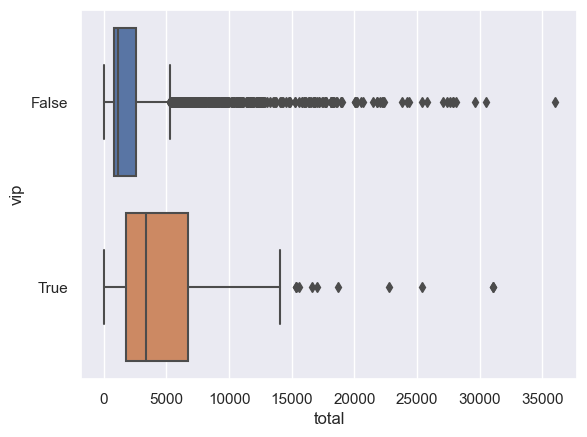

In [146]:
# let's verify our hypothesis
sns.boxplot(data=df, x='total', y='sleep', orient='h')
plt.show()

# let's verify the vip hypothesis

data = df[(df['total'] > 0)]
sns.boxplot(data=data, x='total', y='vip', orient='h')
plt.show()

In [147]:
# the first hypothesis is indeed verified: 
# total == 0 <=> passenger is asleep

# the second hypothesis, is relatively in the correct direction, the mean spending of a vip passenger is significantly 
# larger than the non-vip passenger. it is not possible to determine with high certainty that a high spender is a vip

def impute_total_sleep(row):
    if row['total'] == 0 or row['sleep']:
        for c in spending_cols:
            row[c] = 0
        row['sleep'] = True
        
    return row

In [148]:
spending_cols.append('total')
df_spent = df[df['total']>0]
df_spent_vip = pd.pivot_table(data=df_spent, index=['vip'], values=spending_cols, aggfunc=['median'])
print(df_spent_vip)

      median                                 
        deck   food mall  room    spa   total
vip                                          
False   11.5   16.0  7.0  12.0   19.0  1154.0
True   132.0  488.0  1.0   7.0  133.0  3332.0


In [149]:
import math

def impute_total_vip(row):
    if math.isnan(row['vip']):
        # set the rows with 'vip' missing values to either True or False depending on the
        # total spending 
        if row['total'] > df_spent_vip.loc[False, ('median', 'total')]:
            row['vip'] = True
        else:
            row['vip'] = False
     
    for c in spending_cols:
        if math.isnan(row[c]):
            row[c] = df_spent_vip.loc[row['vip'], ('median', c)]
    return row

df, df_test = apply_functions(df, df_test, impute_total_sleep)
df, df_test = apply_functions(df, df_test, impute_total_vip)

In [150]:
# let's use the median for the moment to impute age
# and the mode for des and home features
from sklearn.impute import SimpleImputer

mode_imputer = SimpleImputer(strategy='most_frequent', missing_values=pd.NA)
median_imputer = SimpleImputer(strategy='median')

# impute des and home features

planets=['home', 'des']

df [planets] = pd.DataFrame(data=mode_imputer.fit_transform(df[planets]), columns=planets)
df [['age']] = pd.DataFrame(data=median_imputer.fit_transform(df[['age']]), columns=['age'])

df_test[planets] = pd.DataFrame(data=mode_imputer.transform(df_test[planets]), columns=planets)
df_test[['age']] = pd.DataFrame(data=median_imputer.transform(df_test[['age']]), columns=['age'])


In [151]:
# as expected we have no missing values anymore
draw_missing_data_table(df)

,Total,Percent
home,0,0.0
sleep,0,0.0
des,0,0.0
age,0,0.0
vip,0,0.0
room,0,0.0
food,0,0.0
mall,0,0.0
spa,0,0.0
deck,0,0.0


In [152]:
# final step in the baseline pipeline is to encode the categorial features 
# and convert the boolean ones numerical

df = one_hot_encoder(df, planets)
df_test = one_hot_encoder(df_test, planets)

# remove the original columns
df, df_test = drop_cols(planets, df, df_test)

def set_bool_int(row):
    row['sleep'] = int(row['sleep'])
    row['vip'] = int(row['vip'])
    return row

df, df_test = apply_functions(df, df_test, set_bool_int)


[array(['Ea', 'Eu', 'Ma'], dtype=object)]
[array(['C', 'P', 'T'], dtype=object)]
[array(['Ea', 'Eu', 'Ma'], dtype=object)]
[array(['C', 'P', 'T'], dtype=object)]


before proceeding with the evaluation, I am using an external python file with a number of helper functions mainly concerning hyperparameter tuning and model selection. The cell below will download it for you!!

The average accuracy of cross validation: 0.7874172755131548


LogisticRegression(C=0.008858667904100823, max_iter=5000)

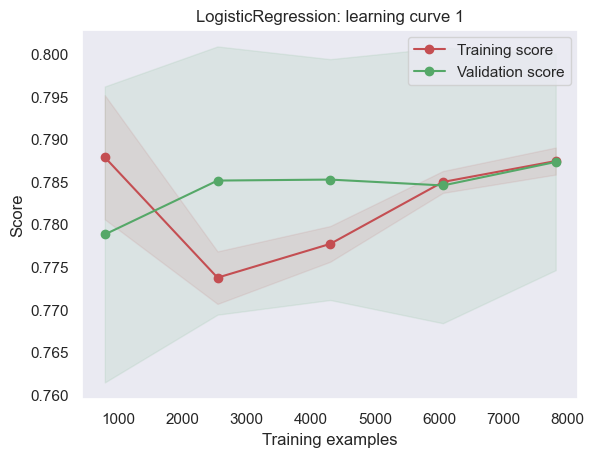

In [153]:
# let's remove the 'y' column from the training dataset 
df.pop('y')
from classifiers import tune_model
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=5000)
grid= {"C":np.logspace(-3, 3, 20)}

classification_model(lr,"LogisticRegression", grid, df, y)

In [154]:
# even though it is clear that Logistic Regression is underfitting the problem
# let's test it on the platfor
create_submission(lr, df, y, df_test, "Logistic Regression")
# the baseline submission scored an accuray of 0.78816
# let's see how far accurate our model can be!!

# the current training and test datasets will be saved to evaluate the changes introduced later down the road
train1 = df.copy()
test1 = df_test.copy()

# improving further
In this section I will try to apply a number of feature engineering techniques, further data cleaning and analysis to boost the model's performance. 
Among the points to address:
* attempt to extract insights from cabin and name columns
* address the outliers in the spending columns + vip column
* better encoding and impuation for home and des columns


In [155]:
# let's reconsider the original dataset
df = df_org.copy()
df_test = df_test_org.copy()
# let's first add the total column
# as well as impute the sleep and the spending columns
df, df_test = apply_functions(df, df_test, total_spent)
df, df_test = apply_functions(df, df_test, impute_total_sleep)

In [156]:
# let's see how 'home' and 'des' features interact with the rest of the features
# outside of the spending columns, consider only the "total" feature 
use_cols = [c for c in df.columns if c not in ['mall', 'food', 'room','deck', 'spa']]

# for c in use_cols:
#     visualize_interaction(df, c, use_cols=use_cols, num_cat='hist')

* Passengers from Eu do not go to "P" and "Ma" passengers prefer travelling to "T"
* Passngers from "Ea" are not vip passengers
* Passengers form "Eu" tend tp spend more money than the rest (but more than 2 thirds of them are transported) 
* The interaction between sleep and vip, shows that none of the vip passengers sleep, this can be used to impute vip: sleep: $\implies$ vip = False
* considering the distribution of the different services with the diferent values of sleep, we can say that sleeping passengers are highly likely not to spend money on any of the services, which is also reflected in the passenger's classification
* vip passengers spend more money than non-vip passengers


## Does destination or origin matter ?

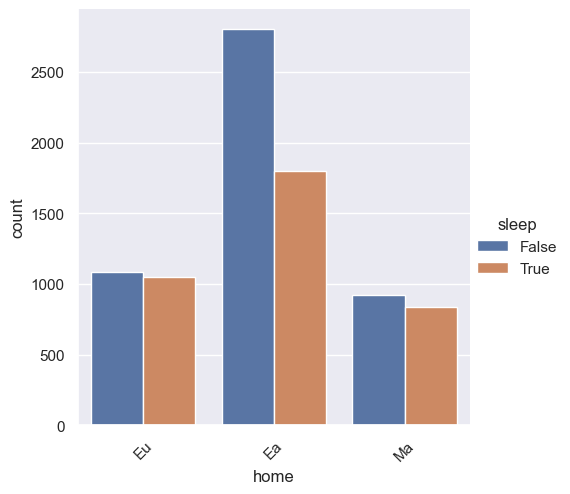

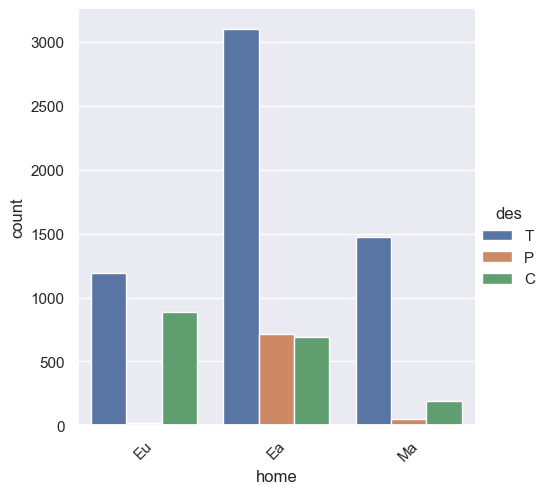

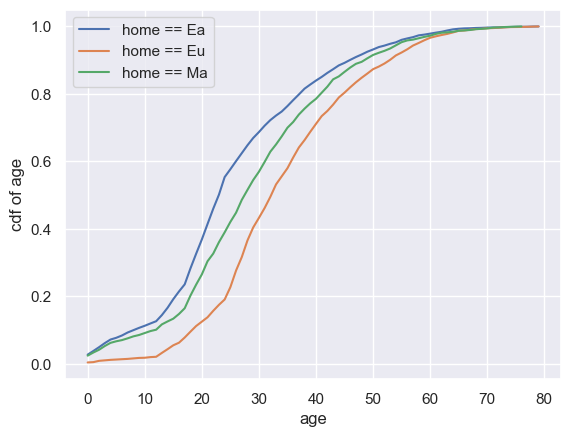

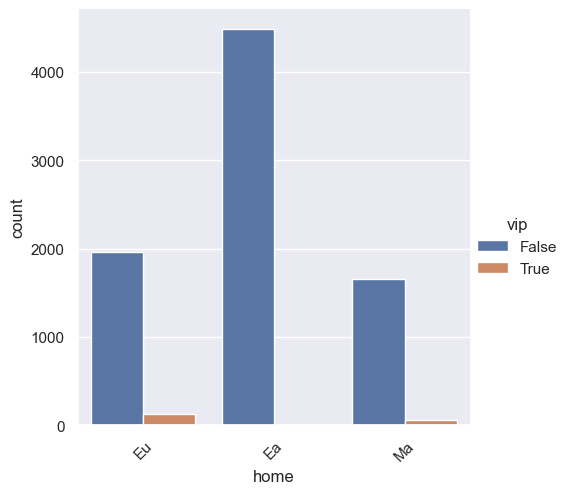

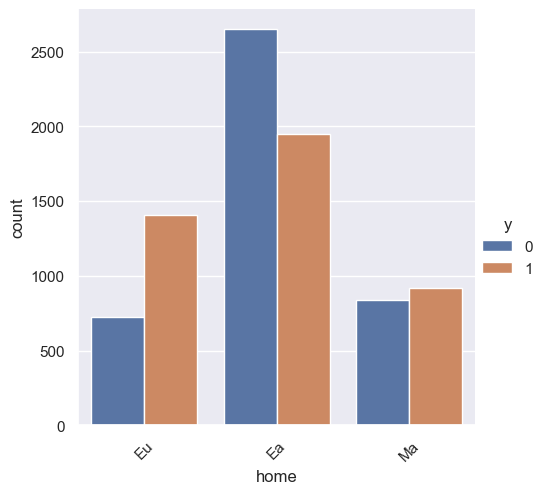

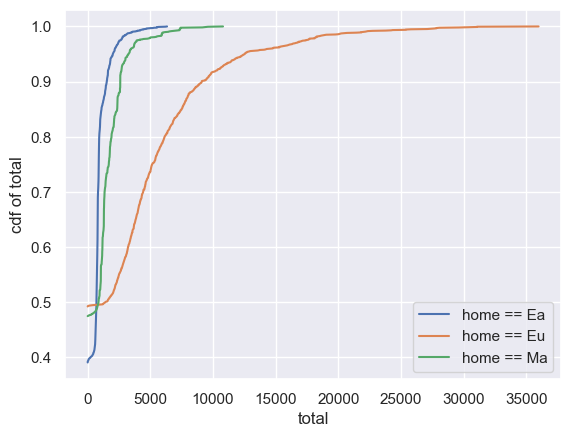

In [157]:
visualize_interaction(df, 'home', use_cols=use_cols, num_cat='cdf')

* Earth has the most passengers
* Europa's passengers do not visit PSO
* Earth has no vip people
* Europe is the richest planet and with 2 thirds of its passengers getting transported

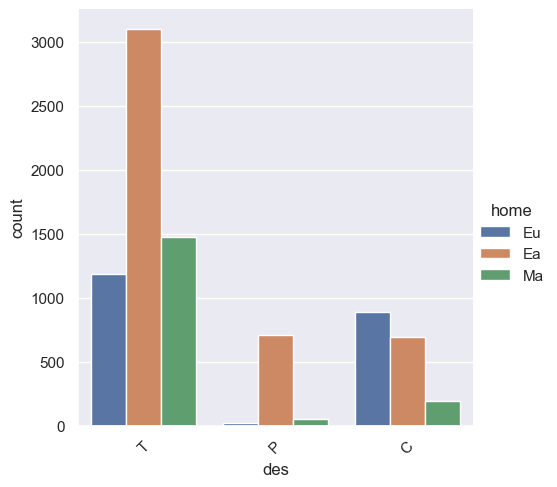

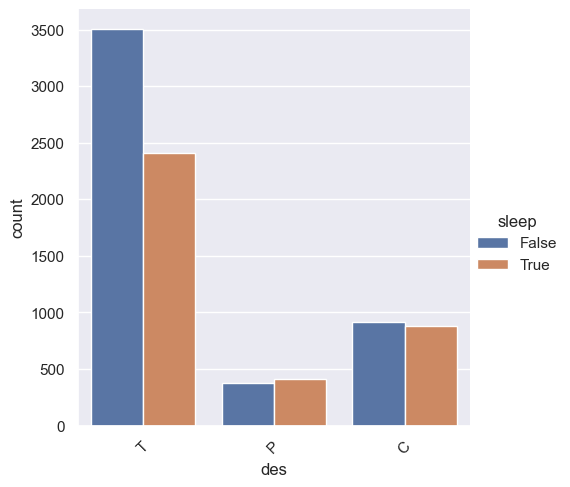

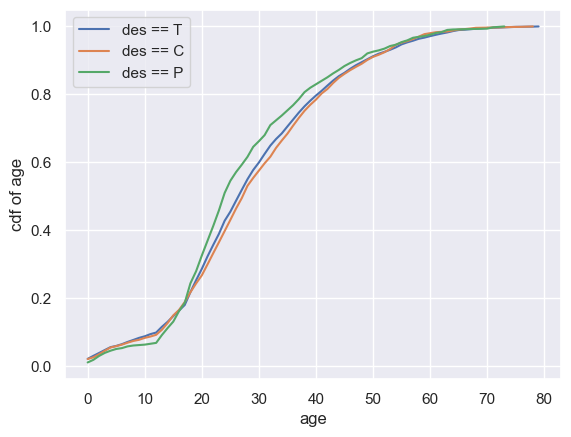

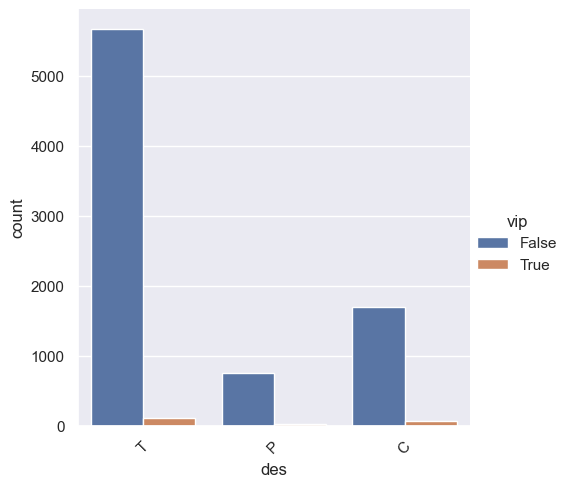

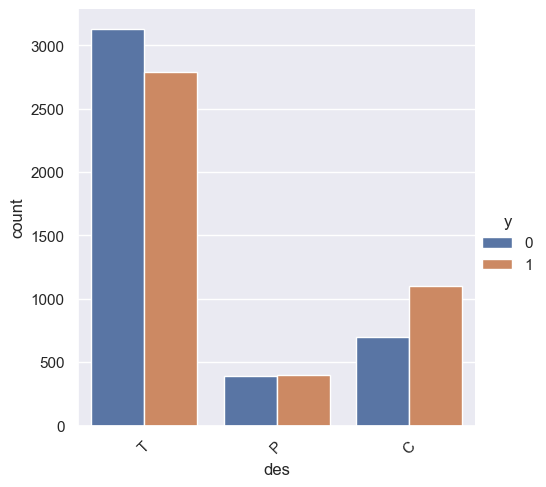

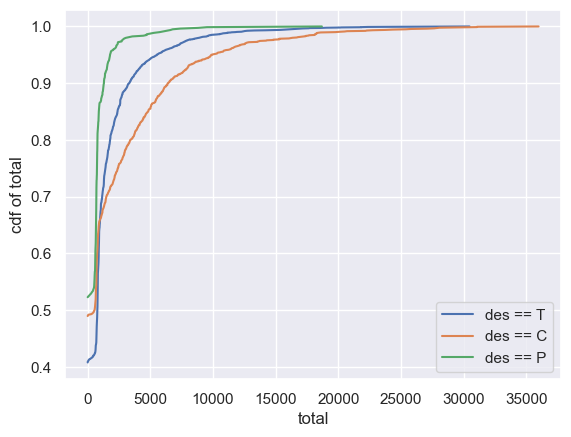

In [158]:
# it is clear that Europa's passengers are less likely to get transported than the rest. All the rich passengers are mainly from that planet
# let's consider the 'des' feature
visualize_interaction(df, 'des', use_cols=use_cols, num_cat='cdf')

In [159]:
# after calling 
# visualize_interaction(df, 'des', use_cols=use_cols) 
# the 'des' features was deemed non-informative
# thus, it seems reasonable to binarize the 'home' feature and drop the 'des' feature

eu= 'Eu'
ma = "Ma"

# let's calculate q3 for Mars
q3_mars = np.quantile(df[df['home'] == ma]['total'], [0.75])[0]
print(q3_mars)

# let's binarize the 'home' feature while 
def new_home(row):
    # let's try to impute the value if it is nan:
    try:
        if math.isnan(row['home']):
            # if the destination is 'POS'... then "home" is not Europe
            try:
                if row['des'] =='P' or row['total'] <= q3_mars:
                    row['is_Europe'] = False
                else: 
                    row['is_Europe'] = True
            except AttributeError:
                # this block is accessed if row['des'] or row['total'] is nan
                # statistically, having the passenger's home as Europe is less likely than other planets
                row['is_Europe'] = False   
       
    except TypeError:
        # a TypeError means row['home'] is not Nan
        row['is_Europe'] = row['home'] == eu

    return row


1686.5


In [160]:
df, df_test = apply_functions(df, df_test, new_home)

# drop the home and des features
df, df_test = drop_cols(['des', 'home'], df, df_test)

## Spending Outliers
the distribution of the spending features (for the two classes) show that passengers with higher spendings are less likely to get transported. Nevertheless, the data is highly skewed and thus the outliers should be considered separtely from the non-outliers to gain better insights 

In [161]:
print(df[df['total']==0].shape)
# more than 40% of the passengers are asleep
# depending on the spending columns, we have 3 types of passengers: asleep, awake non-outlier, outlier
# an outlier will be defined as a passenger spending extravagently in at least on service
# each type will be considered separetely

(3772, 13)


### An outlier getting transported, why ??

In [162]:
# let's define a function to extract the necessary percentiles
def outliers (df:pd.DataFrame, spending_col):  
    data = df[df[spending_col] > 0]
    q1, q3 = np.quantile(np.asarray(data[spending_col]), [0.25, 0.75])
    iqr = q3 - q1
    min_ = max(0, q1 - 1.5 * iqr)
    max_ = q3 + 1.5 * iqr
    return min_, max_

spending_limits = dict(zip(spending_cols, [outliers(df, c) for c in spending_cols]))
print(spending_limits)

{'deck': (0, 1971.5), 'room': (0, 2065.125), 'food': (0, 3025.75), 'spa': (0, 1882.0), 'mall': (0, 1699.5), 'total': (0, 5401.0)}


In [163]:
sp_out = 'spending_outlier'
def set_spending_outliers(row):
    global spending_limits
    spending_cols = ['deck','room','food','spa', 'mall', 'total']
    row[sp_out] = 0
    for c in spending_cols:
        limits = spending_limits[c]
        if row[c] > limits[1] or row[c] < limits[0]:
            row[sp_out] += 1
    return row


df, df_test = apply_functions(df, df_test, set_spending_outliers)

In [164]:
# what is special about these outlier
df_outliers = df[df[sp_out] > 0]
num, cat = get_col_types(df_outliers)

print(df_outliers['y'].value_counts())
print(f"{df_outliers['y'].value_counts()[0] / df_outliers['y'].value_counts().sum()} of the outliers are not transported")

0    783
1    384
Name: y, dtype: int64
0.6709511568123393 of the outliers are not transported


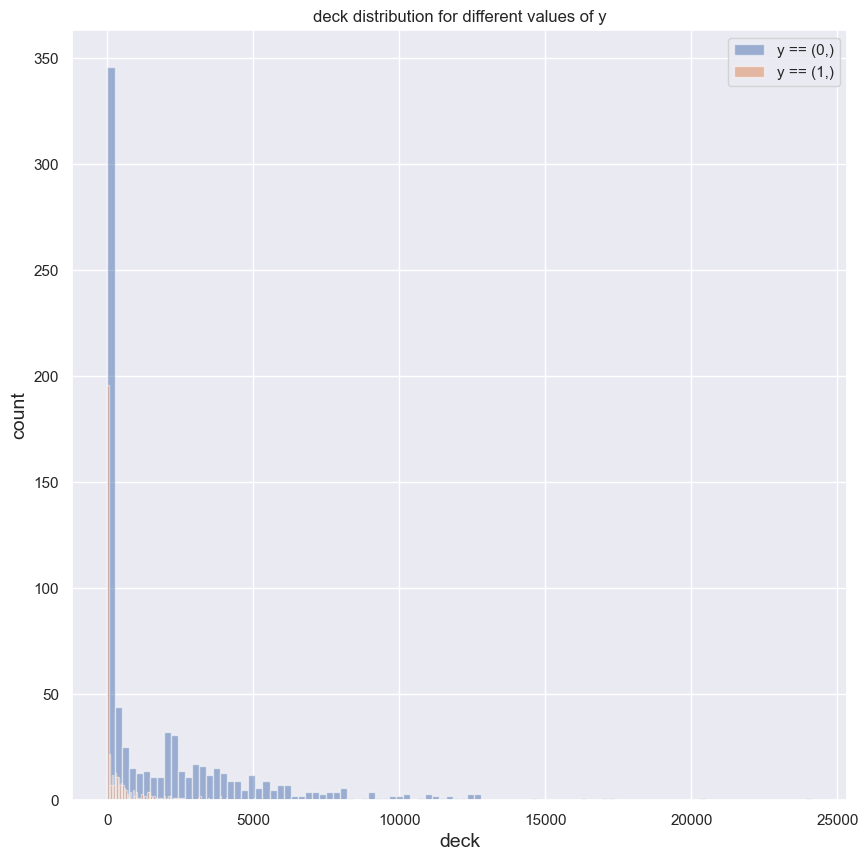

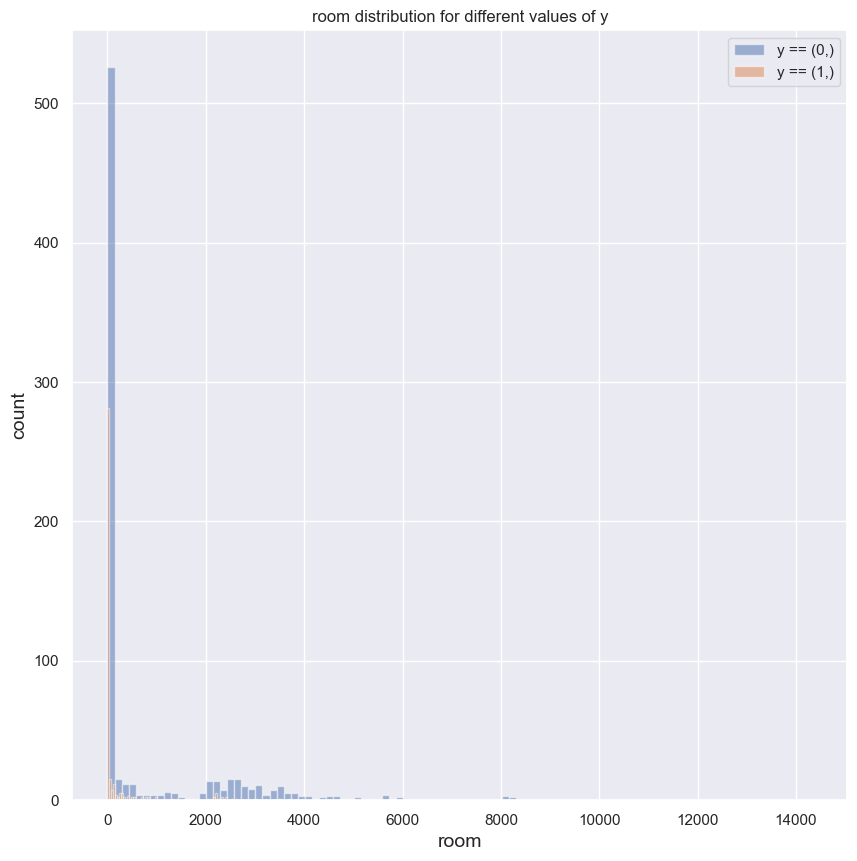

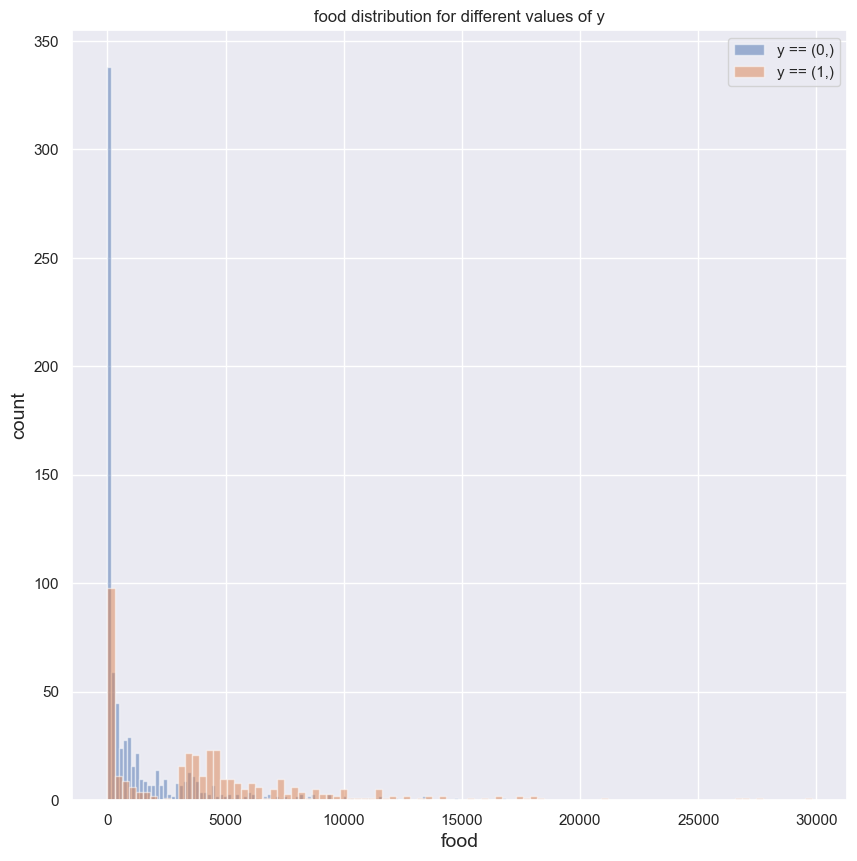

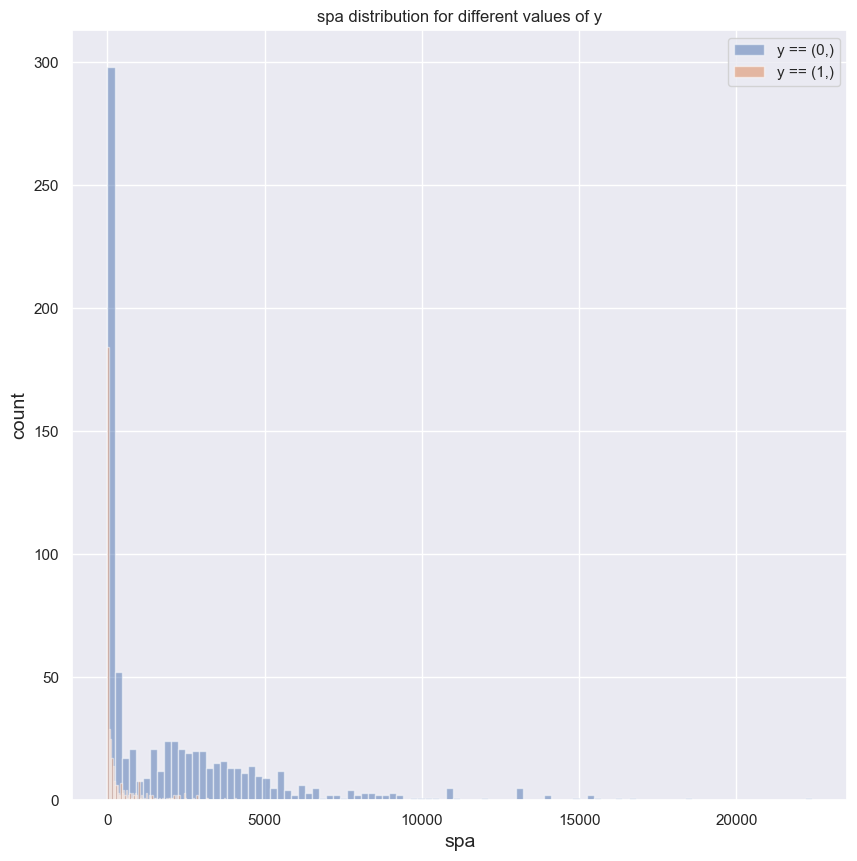

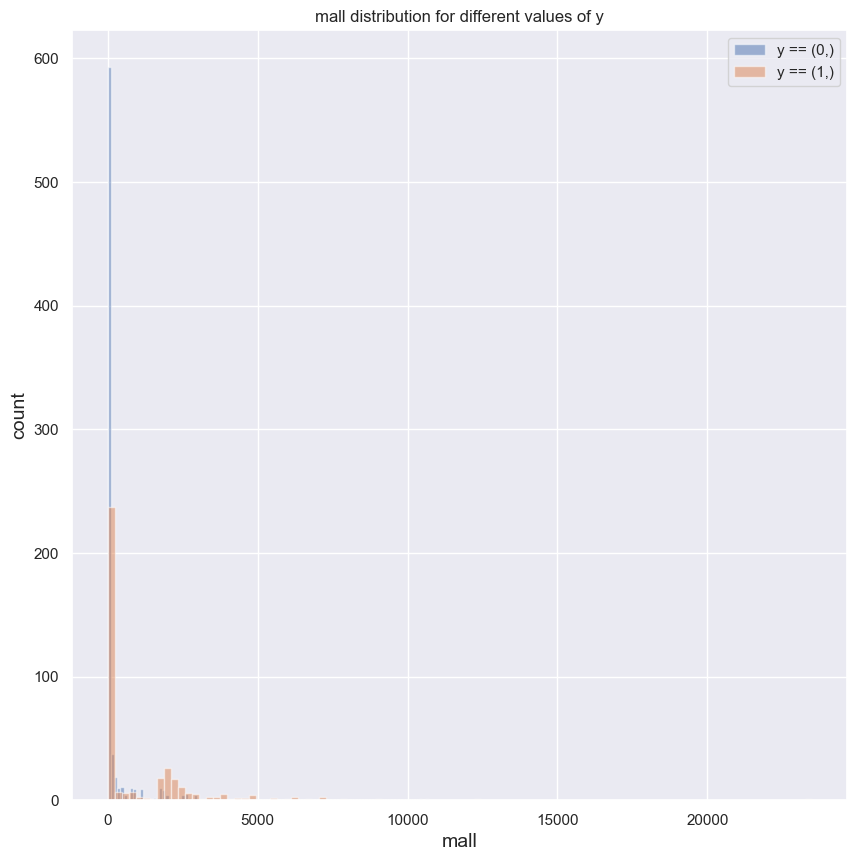

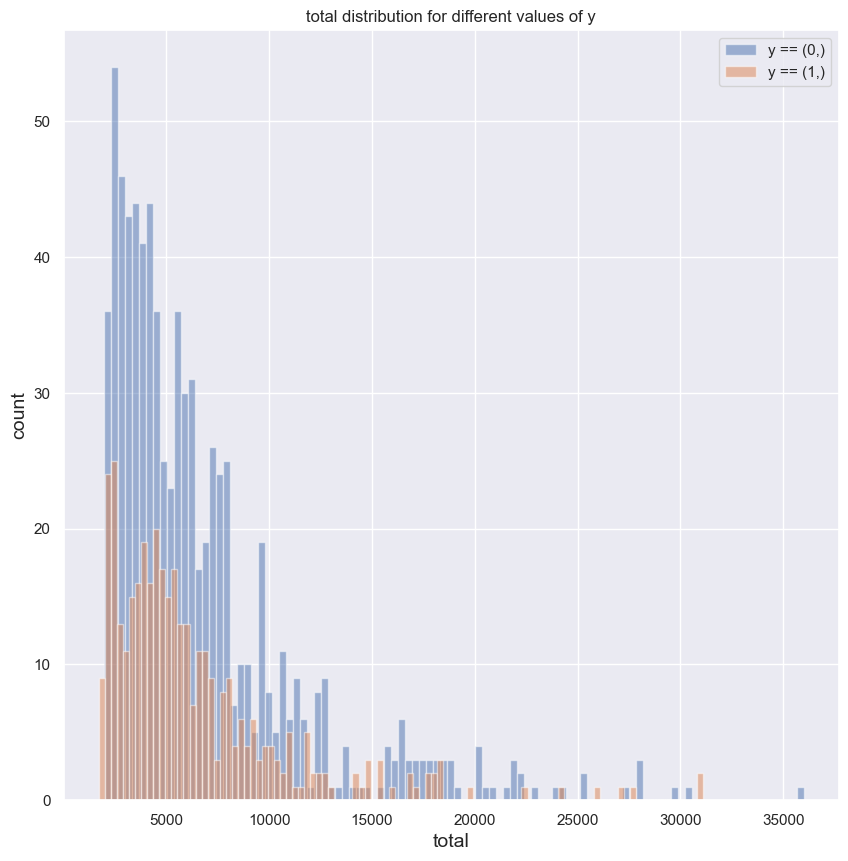

In [165]:
# why would an outlier get transported ?
for sp in spending_cols: 
    visualize_interaction(df_outliers, feature=sp,use_cols='y', num_cat='hist')

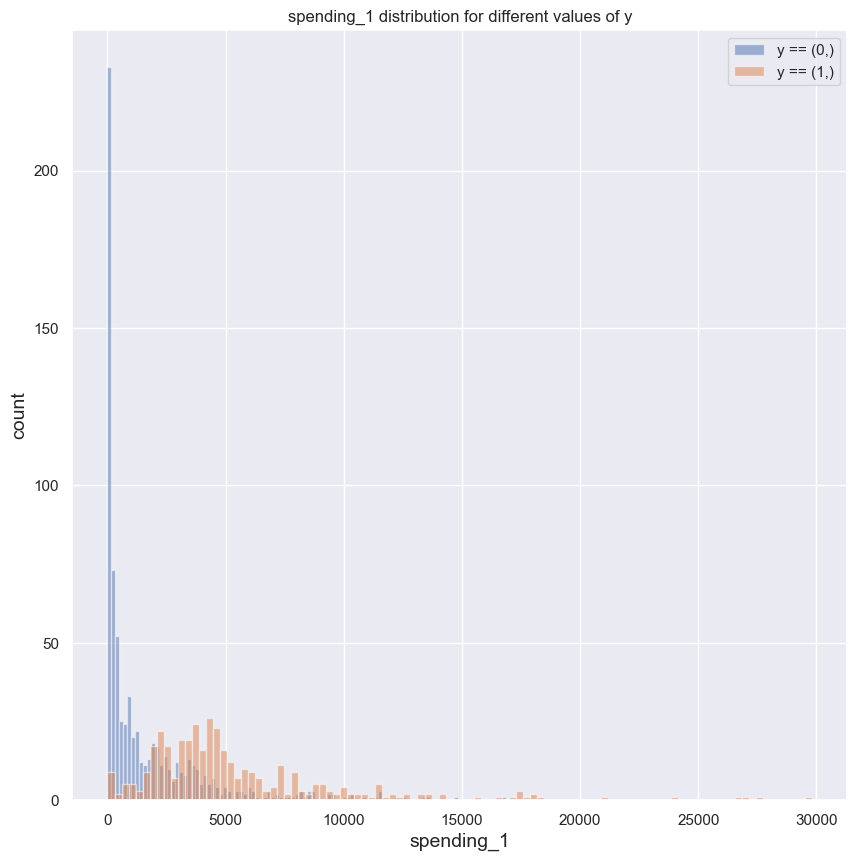

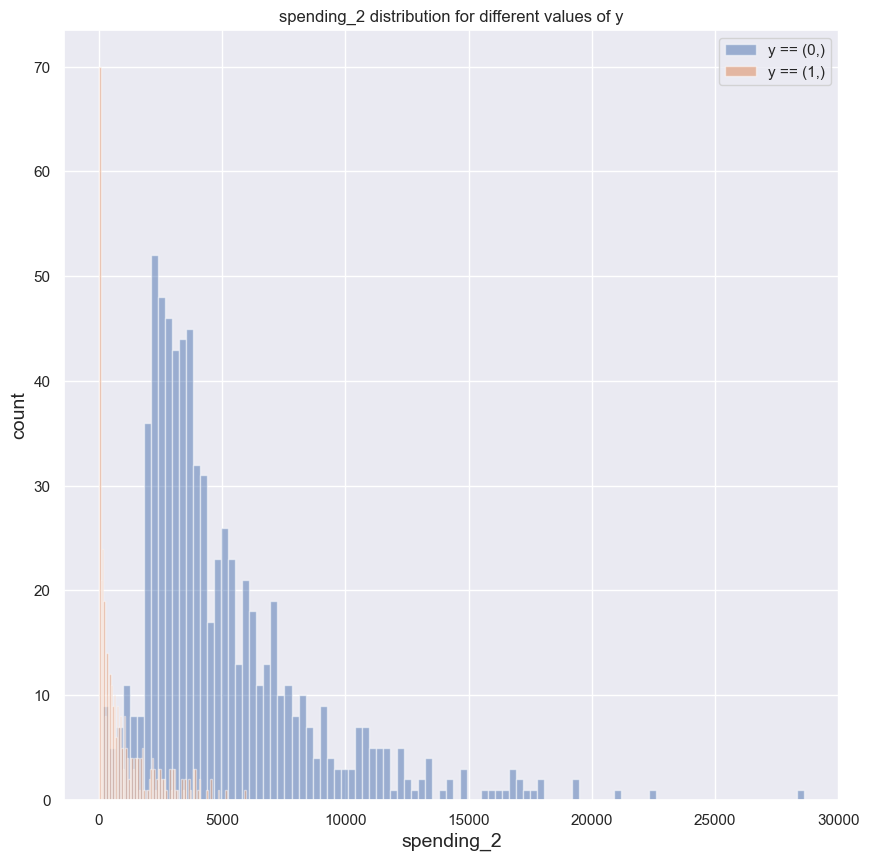

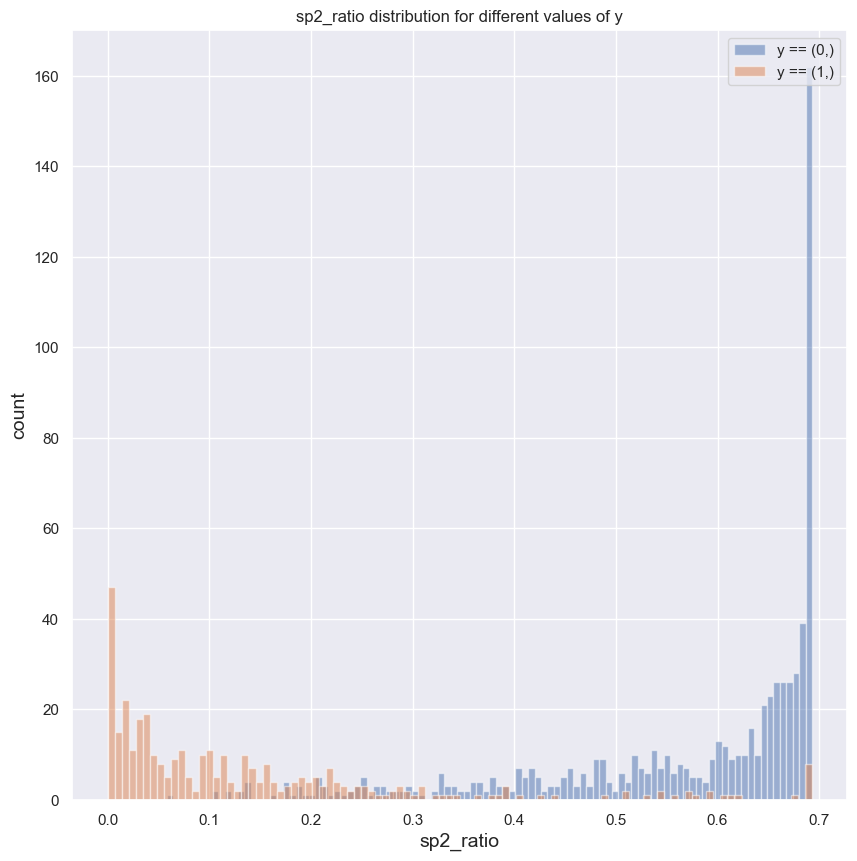

sleep                    NaN
age                -0.061376
room               -0.204928
food                0.389674
mall                0.257674
spa                -0.326860
deck               -0.291410
y                   1.000000
total              -0.032246
is_Europe           0.056012
spending_outlier   -0.101683
spending_1          0.483834
spending_2         -0.541869
sp2_ratio          -0.802752
Name: y, dtype: float64


In [166]:
# one observation is that deck, spa and room can have similar behavior while food and mall can be grouped as a different cluster
# let's invertiage this a bit further
def spending_types(row):
    row['spending_1'] = row['mall'] + row['food']
    row['spending_2'] = row['deck'] + row['room'] + row['spa']
    # let's consider the ratio between the trwo different types
    row['sp2_ratio'] = np.log(1 + (row['spending_2'] / (1 + row['spending_2'] + row['spending_1'])))
    return row

df_outliers = df_outliers.apply(spending_types, axis=1)
# look for any noticeable differences
sp = ['spending_1', 'spending_2', 'sp2_ratio']
for s in sp:
    visualize_interaction(df_outliers, s, use_cols='y', num_cat='hist')

print(df_outliers.corr(numeric_only=True)['y'])

### Awake but non-outliers ? 

In [167]:
# let's consider the non-outliers
df_no = df[(df[sp_out] == 0) & (df['total'] > 0)]
df_t_no = df_test[(df_test[sp_out] == 0) &  (df_test['total'] > 0)]

In [168]:

# for d in df_no.columns:
#     visualize_interaction(df_no, d, 'y', num_cat='hist')

#  once again the features present do not seem very deterministic for this category of passengers
# let's consider the spending_1 / 2 features introduced for the previous category
df_no = df_no.apply(spending_types, axis=1)
for s in sp:
    visualize_interaction(df_no, s, ['y'], num_cat='hist')


### getting transported while sleeping...

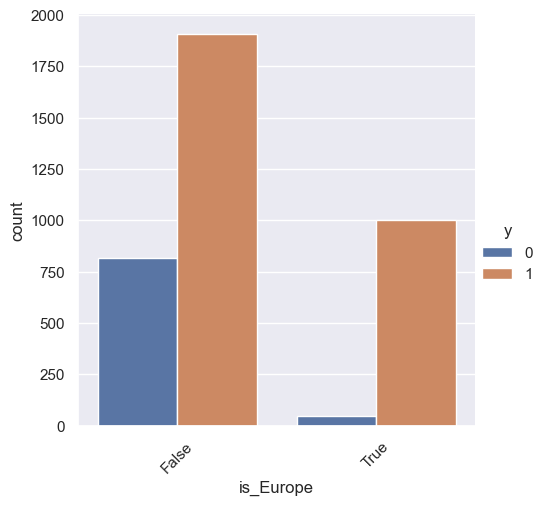

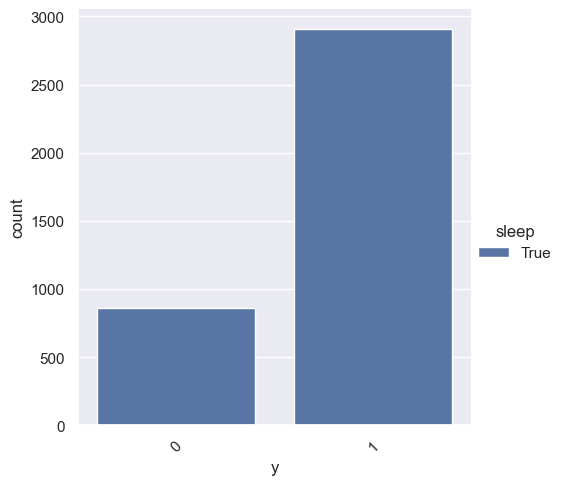

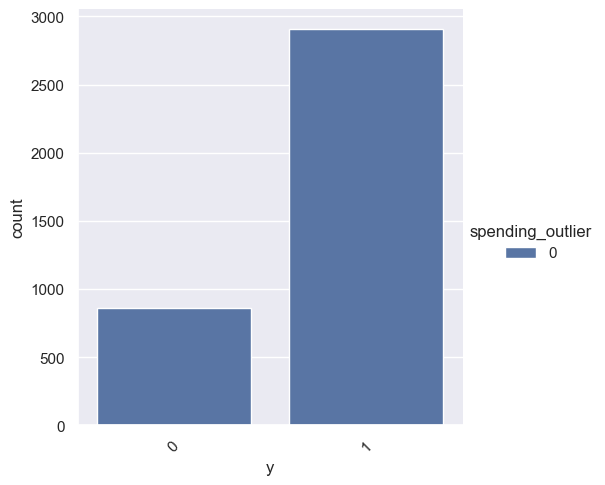

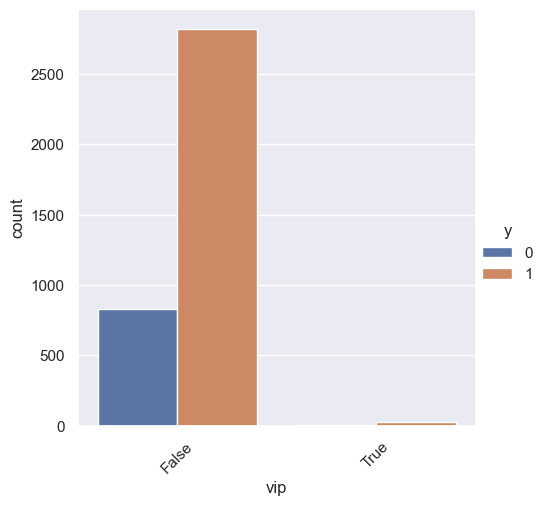

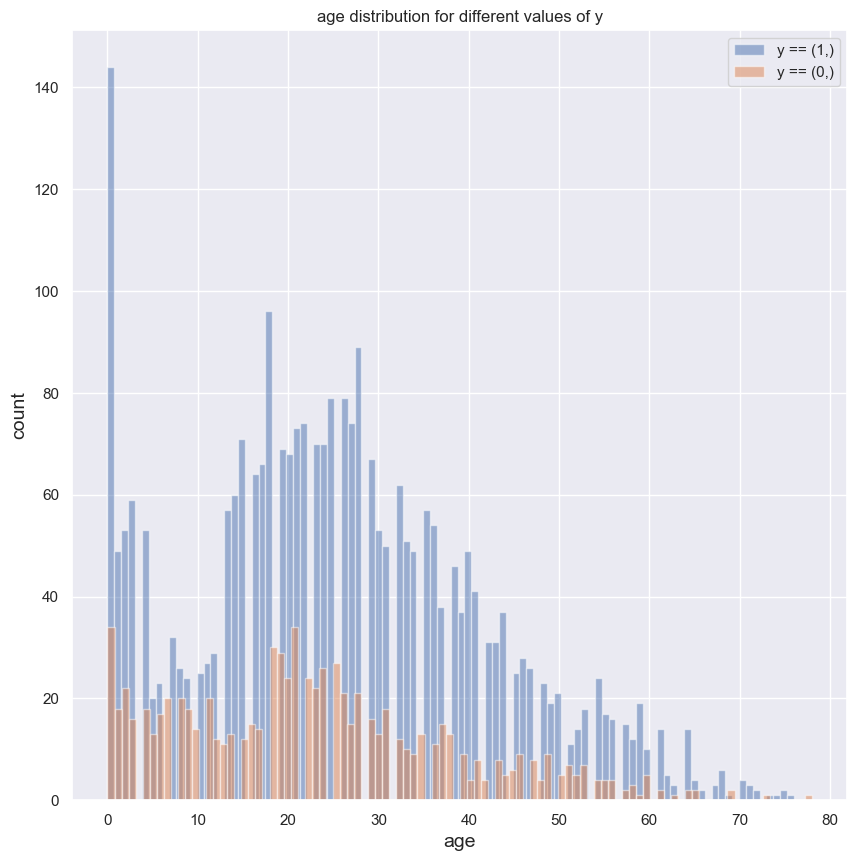

In [ ]:
df_s = df[df['total'] == 0]
# as all spending columns are set to 0, let;s consider only categorical features + age
num, cat = get_col_types(df)
for col in cat:
    visualize_interaction(df_s, col, 'y', num_cat='hist')

visualize_interaction(df_s, 'age', 'y', num_cat='hist')

The most informative feature for sleeping passengers is currently 'is_Europe'. As most sleeping European passengers get transported. However, the fact preventing sleeping passengers' transportation is still unknown.

## result of iteration 1

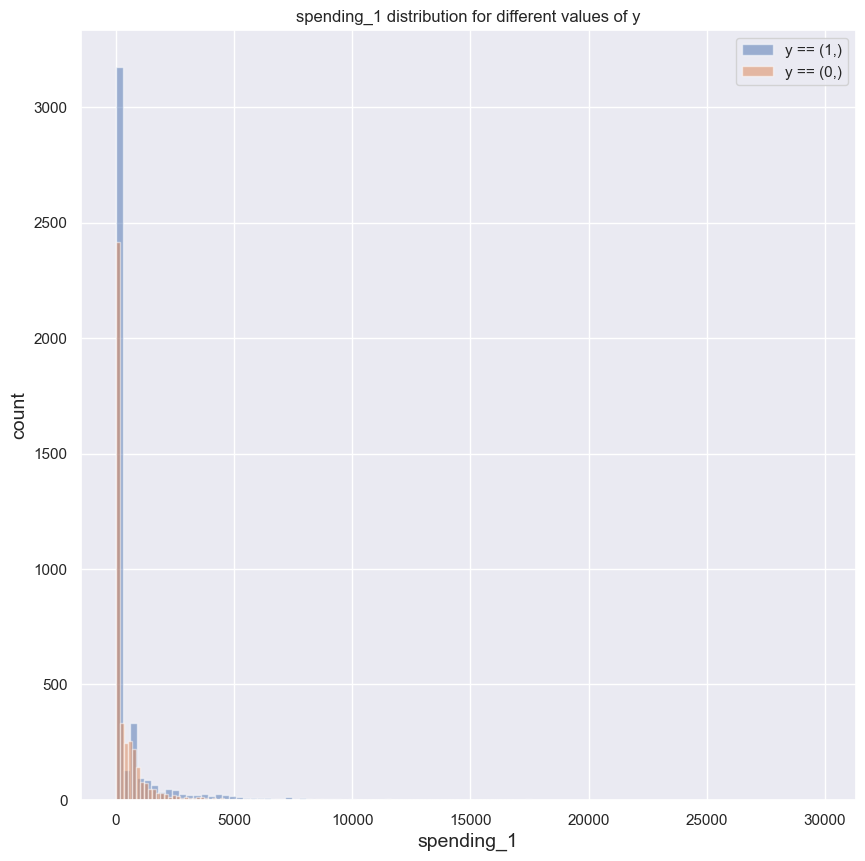

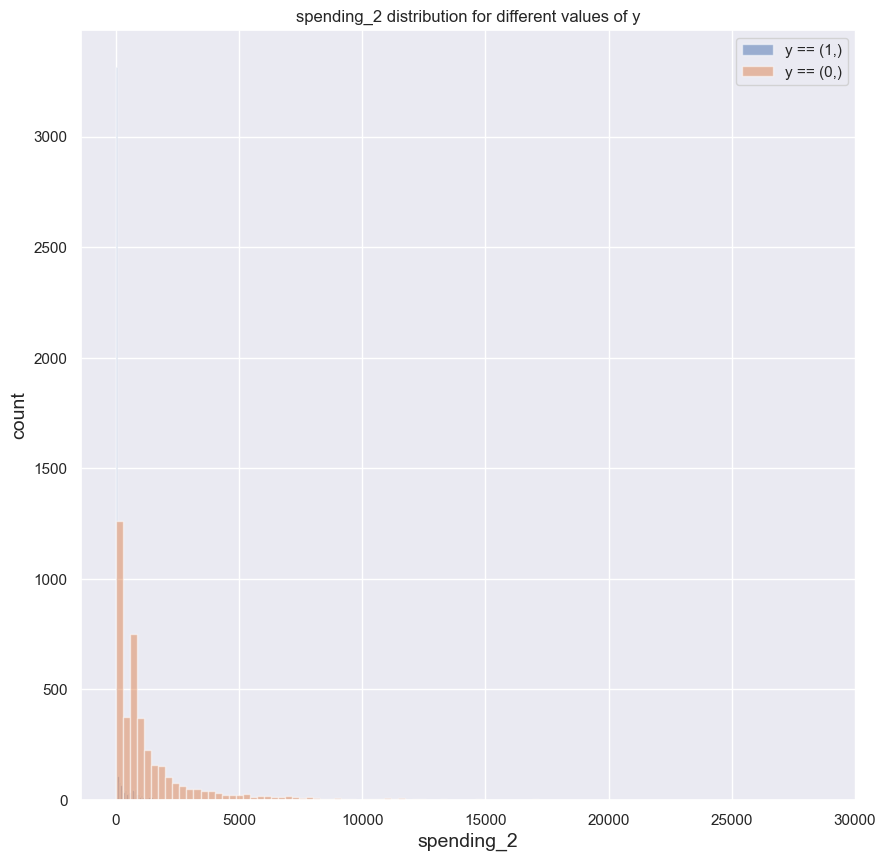

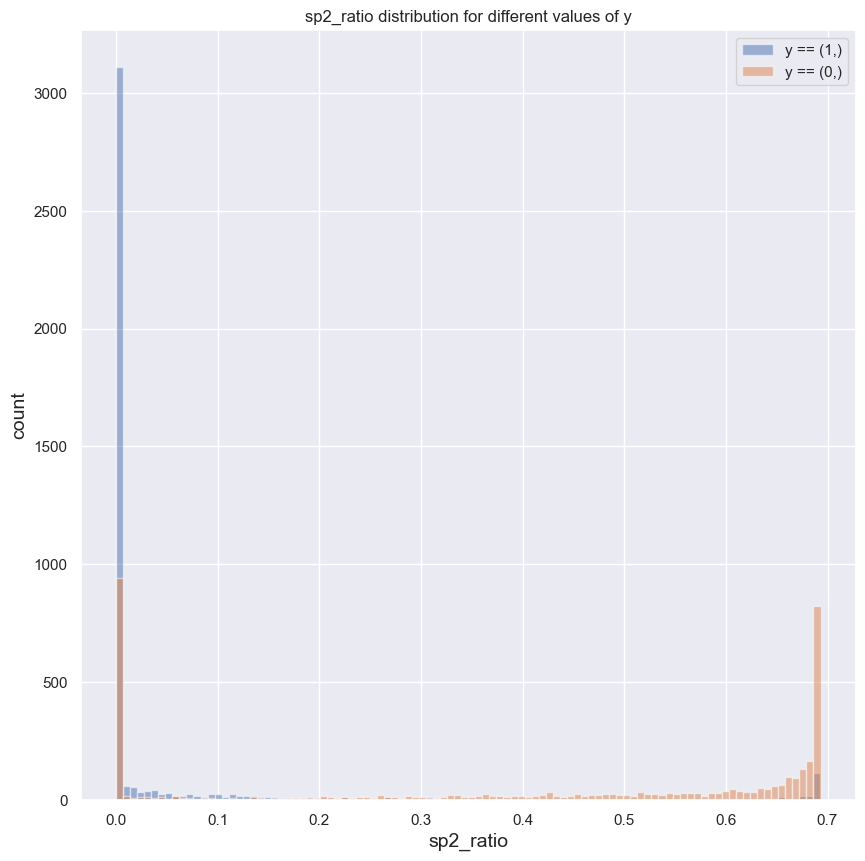

In [ ]:
# before proceeding with adding more features, let's consider testing Linear regression with the current additions
# keeping only spending_1 and spending_2: (apply transformations)
# considering the new feature is_Europe
# let's apply the spending_types function
df, df_test = apply_functions(df, df_test, spending_types)
# let;s visualize the distributions
for s in sp:
    visualize_interaction(df, s, 'y', num_cat='hist')

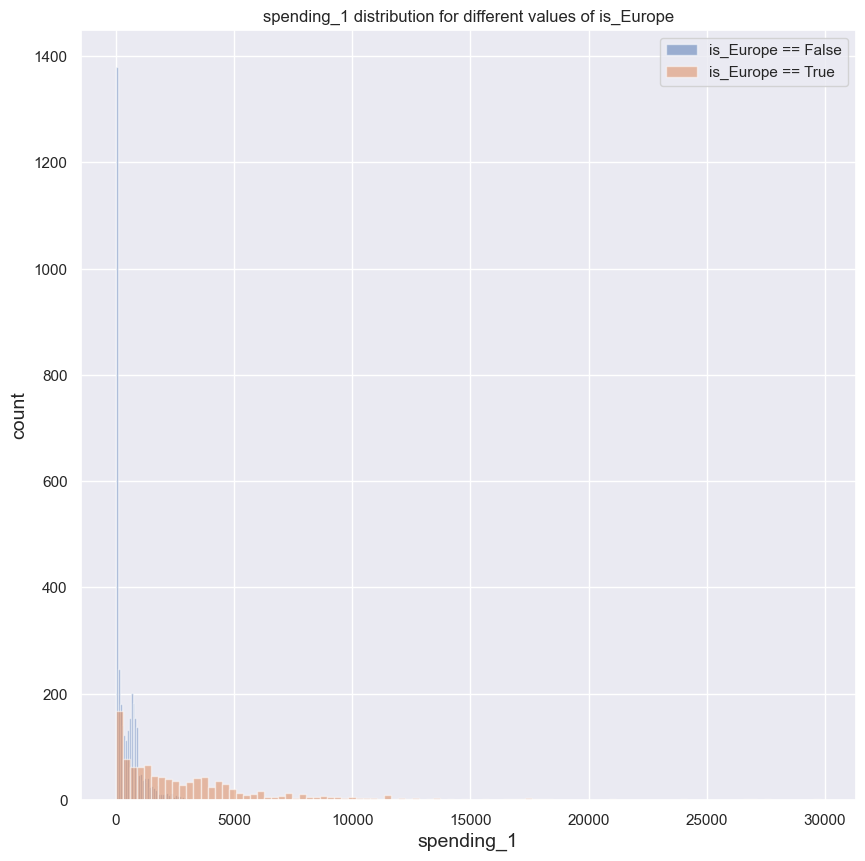

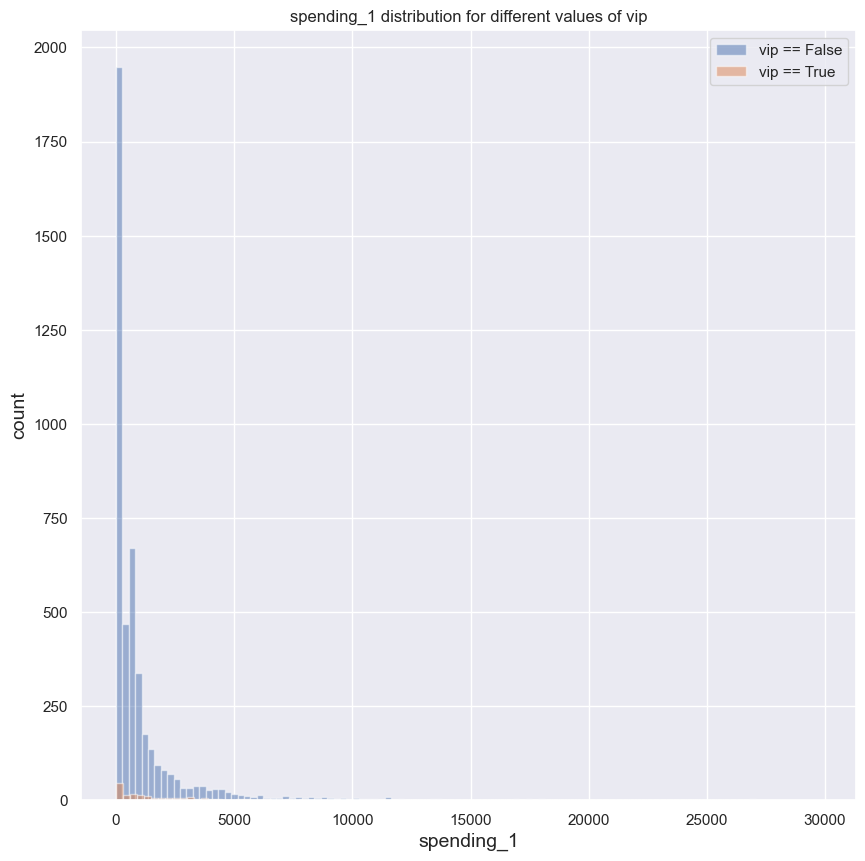

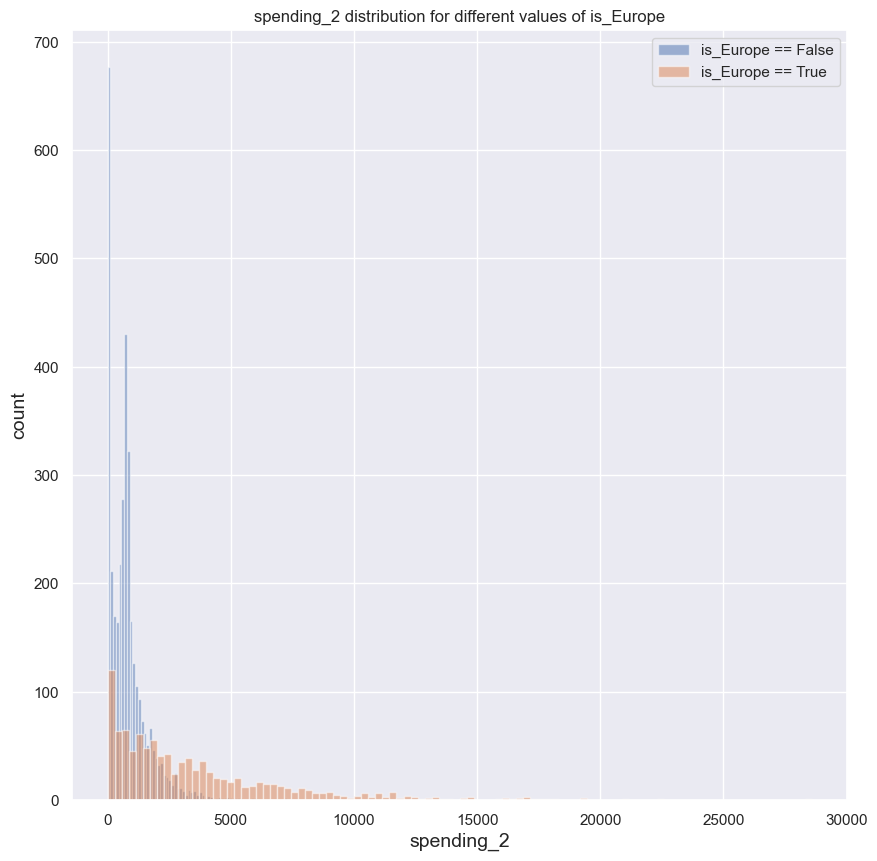

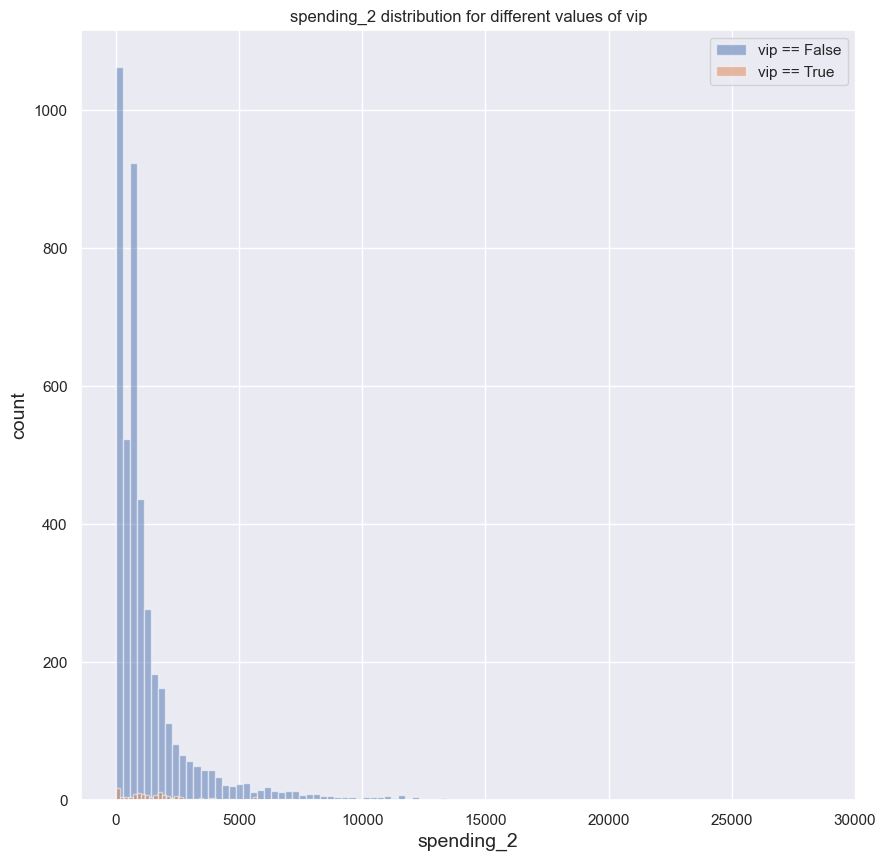

In [ ]:
# the missing values for spending_1 and spending_2 can be imputed depending on 
# for imputation purposes, let's try to understand how the values of categorical features, affect spending_1, spending_2
visualize_interaction(df[df['total'] > 0], 'spending_1',use_cols=['is_Europe', 'vip'], num_cat='hist')
visualize_interaction(df[df['total'] > 0], 'spending_2', use_cols=['is_Europe', 'vip'], num_cat='hist')

In [ ]:
# spending_2 seems quite informative
# let's check the correlation here
print(df.corr(numeric_only=True)['y'])
# transformations ?: a combination of reciprocal and logarithm functions

df, df_test = apply_functions(df, df_test, funcs=[lambda x: 1 / (1 + np.log(1 + x))] * 2, col_names=['spending_1', 'spending_2']) 

print(df.corr(numeric_only=True)['y'])



sleep               0.468093
age                -0.075026
room               -0.241653
food                0.043145
mall                0.009564
spa                -0.217716
deck               -0.203959
y                   1.000000
total              -0.195425
is_Europe           0.176916
spending_outlier   -0.138181
spending_1          0.042672
spending_2         -0.350373
sp2_ratio          -0.587872
Name: y, dtype: float64
sleep               0.468093
age                -0.075026
room               -0.241653
food                0.043145
mall                0.009564
spa                -0.217716
deck               -0.203959
y                   1.000000
total              -0.195425
is_Europe           0.176916
spending_outlier   -0.138181
spending_1          0.344742
spending_2          0.500671
sp2_ratio          -0.587872
Name: y, dtype: float64


In [ ]:
# let's spending_outliers to a binary value
def binary_sp_outliers(row):
    row['spending_outlier'] = row['spending_outlier'] > 0
    return row

def impute_vip_sleep(row):
    if row['sleep']: 
        row['vip'] = False
    return row
# we can see that the distribution of spendings_1/ 2 is within limited range for passengers where is_Europe or vip are true
# let's use this information for imputation purposes

eu_sp1_median = df[(df['total']  > 0) & (df['is_Europe'])]['spending_1'].median()
eu_sp2_median = df[(df['total']  > 0) & (df['is_Europe'])]['spending_2'].median()
vip_sp1_median = df[(df['total']  > 0) & (df['vip'])]['spending_1'].median()
vip_sp2_median = df[(df['total']  > 0) & (df['vip'])]['spending_2'].median()

def impute_spendings(row):
    if math.isnan(row['spending_1']):
        if row['is_Europe']:
            row['spending_1'] = eu_sp1_median
        elif row['vip']:
            row['spending_1'] = vip_sp1_median
    
    if math.isnan(row['spending_2']):
        if row['is_Europe']:
            row['spending_2'] = eu_sp2_median
        elif row['vip']:
            row['spending_2'] = vip_sp2_median

    return row

df, df_test = apply_functions(df, df_test, impute_vip_sleep)
df, df_test = apply_functions(df, df_test, impute_spendings)


In [ ]:
# as for the rest, we will assume missing values are zeros and recalculate the spending columns
df[['mall', 'spa', 'deck', 'room', 'food']]= df[['mall', 'spa', 'deck', 'room', 'food']].fillna(value=0)
df_test[['mall', 'spa', 'deck', 'room', 'food']]= df_test[['mall', 'spa', 'deck', 'room', 'food']].fillna(value=0)
# recalculate the spending features
df, df_test = apply_functions(df, df_test, spending_types)

# if passengers have are outliers, we can assume they are vip, otherwise they are not
def impute_vip_outlier(row):
    if math.isnan(row['vip']):
        row['vip'] = row['spending_outlier']
    return row

df, df_test = apply_functions(df, df_test, impute_vip_outlier)

# use median imputation for the age column (copy the code from above xD)
median_imputer = SimpleImputer(strategy='median')

df [['age']] = pd.DataFrame(data=median_imputer.fit_transform(df[['age']]), columns=['age'])
df_test[['age']] = pd.DataFrame(data=median_imputer.transform(df_test[['age']]), columns=['age'])

df, df_test = drop_cols(['total', 'mall', 'spa', 'deck', 'room', 'food', 'cabin', 'name'], df, df_test)
print(df.isna().sum().sum(), df_test.isna().sum().sum(), sep='\n')

0
0


In [ ]:
df_iter_1, df_test_iter_1= df.copy(), df_test.copy()
# let's remove the 'y' column from the training dataset 
df.pop('y')

0       0
1       1
2       0
3       0
4       1
       ..
8688    0
8689    0
8690    1
8691    0
8692    1
Name: y, Length: 8693, dtype: int64

The average accuracy of cross validation: 0.7886825689141876
The average accuracy of cross validation: 0.7899481270071089


,Transported
PassengerId,
0013_01,True
0018_01,False
0019_01,True
0021_01,True
0023_01,True
...,...
9266_02,True
9269_01,False
9271_01,True


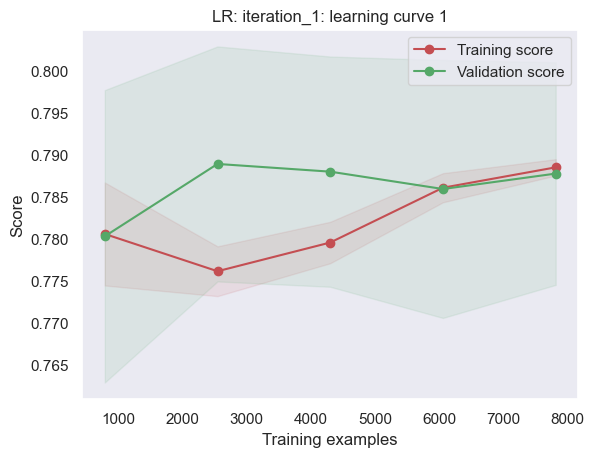

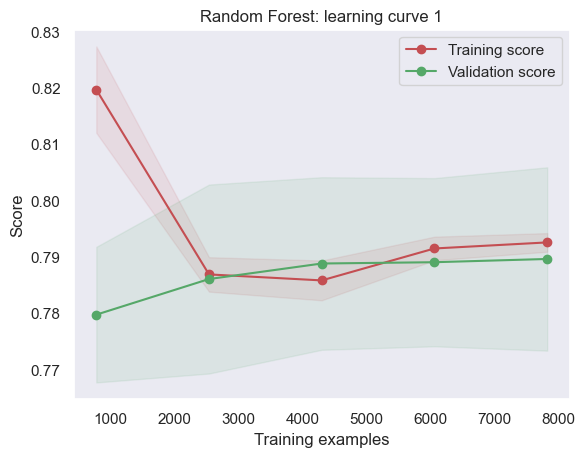

In [ ]:
lr = LogisticRegression(max_iter=5000)
grid= {"C":np.logspace(-3, 3, 20)}

lr = classification_model(lr,"LR: iteration_1", grid, df, y)
create_submission(lr, df, y, df_test, "LR_iteration_1")
# this submission scored 0.78957 accuracy on the test dataset

from sklearn.ensemble import RandomForestClassifier
# let's try more sophisticated models:
rf = RandomForestClassifier(random_state=11)
rf_params = {"n_estimators": [100, 150, 200, 250], "max_depth": range(10, 21, 2), "min_samples_split": np.arange(0.02, 0.041, 0.01), "min_samples_leaf": range(1, 7, 2)}
rf = classification_model(rf, 'Random Forest', rf_params, df, y)
create_submission(rf, df, y, df_test, "RandomForest_iteration_1")


In [ ]:
! pip install xgboost

In [ ]:
import xgboost as xgb
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}

xgbc = xgb.XGBClassifier(seed = 20)
xgbc = classification_model(xgbc, 'XGBoost', params, df, y)
create_submission(xgbc, df, y, df_test, "XGBOOST_iteration_1")

ValueError: 
All the 270 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
270 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\user\AB\temp_venv\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\user\AB\temp_venv\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "c:\Users\user\AB\temp_venv\lib\site-packages\xgboost\sklearn.py", line 1497, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "c:\Users\user\AB\temp_venv\lib\site-packages\xgboost\sklearn.py", line 448, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
  File "c:\Users\user\AB\temp_venv\lib\site-packages\xgboost\sklearn.py", line 934, in _create_dmatrix
    return DMatrix(**kwargs, nthread=self.n_jobs)
  File "c:\Users\user\AB\temp_venv\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "c:\Users\user\AB\temp_venv\lib\site-packages\xgboost\core.py", line 743, in __init__
    handle, feature_names, feature_types = dispatch_data_backend(
  File "c:\Users\user\AB\temp_venv\lib\site-packages\xgboost\data.py", line 957, in dispatch_data_backend
    return _from_pandas_df(data, enable_categorical, missing, threads,
  File "c:\Users\user\AB\temp_venv\lib\site-packages\xgboost\data.py", line 404, in _from_pandas_df
    data, feature_names, feature_types = _transform_pandas_df(
  File "c:\Users\user\AB\temp_venv\lib\site-packages\xgboost\data.py", line 378, in _transform_pandas_df
    _invalid_dataframe_dtype(data)
  File "c:\Users\user\AB\temp_venv\lib\site-packages\xgboost\data.py", line 270, in _invalid_dataframe_dtype
    raise ValueError(msg)
ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:vip: object


## Cabin, Passenger_Id, Name: any insights ? 
After reading the data description more carefully, it can be seen that cabin, passenger_id and name column are not completely useless. Let's see if some feature engineering could put these columns to use

In [ ]:
shit

# let's first restore the passenger_id column
df['id'] = train_data['PassengerId']
df_test['id'] = test_data['PassengerId']

def group_number(row):
    g, n = [int(s) for s in row['id'].strip().split("_")]
    row['group'] = g
    return row

df, df_test = apply_functions(df, df_test, group_number)


NameError: name 'shit' is not defined

In [ ]:
def split_cabin(row):
    try:
        d, n, side = row['cabin'].split("/")
        row['deck_num'] = d
        row['cabin_num'] = n
        row['side'] = side
    except:
        pass
    return row

def split_name(row):
    try:
        row['name'] = row['name'].strip().split(" ")[1].lower()
    except:
        pass
    return row

df, df_test = apply_functions(df, df_test, split_cabin)
df, df_test = apply_functions(df, df_test, split_name)   


In [ ]:
new_feats = ['deck_num', 'cabin_num', 'side', 'name', 'group']
for f in new_feats:
    u = df[f].value_counts()
    if len(u) <= 10:   
        print(u)
    else:
        print(f"feature {f} has {len(u)} unique values")

We can see that there are many families (more than 2200 unique surname). The feature as it is, is not very informative. However, we can assign a number of family members to each passenger. This value can be approximated with high certainty by the value_counts() function call on the "number" feature
however it can be done definitely using the name feature.   
The group, number, cabin_num and name (after preprocessing) features will be discarded 


In [ ]:
# let's use the entire dataset for extracting the family sizes 
alldata = pd.concat([df.drop('y', axis=1), df_test])
group_sizes = alldata.value_counts('group')
fam_sizes = alldata.value_counts('name')

def set_group_size(row):
    # this function is used mainly to later impute the 'fam_size' with the value of the group the row belongs to 
    try:
        row['group'] = group_sizes.loc[row['group']]
    except:
        pass
    return row

def set_fam_size(row):
    try:
        row['fam_size'] = fam_sizes.loc[row['name']]
    except:
        row['fam_size'] = row['group']
    return row 


# make sure to apply the set_group_size first
df, df_test = apply_functions(df, df_test, set_group_size)
df, df_test = apply_functions(df, df_test, set_fam_size)

In [ ]:
# let's consider the interaction of 'fam_size' with the other features
use_cols.remove('home')
use_cols.remove('des')
visualize_interaction(data=df, feature='fam_size', use_cols=use_cols)

## As Dom says , Family First

In [ ]:

# before proceeding to extract insight from grouping the passengers by their families, let's impute the 'name' feature
# the first step is to group the passengers by the 'group' feature, if the 'name' feature is nan for one row, then we can impute it by the most frequent name
# in the 'group' for which that row belongs
from statistics import mode

names_by_group = pd.pivot_table(alldata, values='name', index=['group'], aggfunc=mode)

def impute_name(row):
    global names_by_group
    try:
        if math.isnan(row['name']):
            row['name'] = names_by_group.loc[row['group'], 'name']
        
    except TypeError:
        # this means row['name'] is not nan
        pass
   
    return row

# impute the name feature
df, df_test = apply_functions(df, df_test, impute_name)
print(df['name'].isna().sum(), df_test['name'].isna().sum(), sep='\t')
# fortunately, the set of nan names and nan groups are mutually exclusive, names imputed successfully!!!

In [ ]:
# the final dataframe is the concatenation of all these small modified family frames

def extract_age_in_fam(dataframe:pd.DataFrame):
    new_cols = list(dataframe.columns)
    new_cols.append('age_in_fam')
    new_df = pd.DataFrame([], columns=new_cols)
    by_fam = dataframe.groupby('name')
    for _, fam in by_fam:
        new_frame = fam.reset_index().set_index(pd.RangeIndex(start=1, stop=len(fam) + 1)).reset_index().sort_values(by='age')
        new_frame['age_in_fam'] = (new_frame['level_0']) / len(new_frame)
        new_frame = new_frame.drop('level_0', axis=1).set_index('index')
        new_df = pd.concat([new_df, new_frame], ignore_index=False)
    return new_df

# this function should be applied on the entire data
df['is_train'] = 1
df_test['is_train'] = 0
all_data = pd.concat([df, df_test], ignore_index=False)

all_data = extract_age_in_fam(all_data)

In [ ]:
df = all_data[all_data['is_train'] == 1]
df_test = all_data[all_data['is_train'] == 0]

In [ ]:
# the data's integrity verified
print((train_data.sort_values(by='PassengerId')['PassengerId'].values == df.sort_values(by='id')['id'].values).all())
print((test_data.sort_values(by='PassengerId')['PassengerId'].values == df_test.sort_values(by='id')['id'].values).all())

In [ ]:
# let's consider the mean age and mean spending of each family
family_stats = pd.pivot_table(alldata, index='name', values=['age', 'total'], aggfunc=['mean', 'count', 'median', 'sum', 'max', 'min'])
family_stats

In [ ]:
# the transportation rate differs from one family to another, with 0, 0.5 and 1 being the most common values.
fam_transportation = pd.pivot_table(df, index='name', values=['y'], aggfunc=['mean', 'count'])
# print(fam_survival.sort_values(by=('mean', 'y'), ascending=False)) 
# let's visualize the the distribution of the survival rate among families
fam_transportation.reset_index()[('mean', 'y')].plot(kind='hist')
plt.show()

In [ ]:
# let's add some fam/total, fam/age features

def set_fam_age(row):
    global family_stats
    # consider adding the median age of the passenger's family
    row['fam_age'] = family_stats.loc[row['name'], ('median', 'age')]    
    return row

def set_fam_total(row):
    global family_stats
    row['fam_total_frac'] = min(1, row['total'] / (family_stats.loc[row['name'], ('sum', 'total')] + 1))  
    return row

df, df_test = apply_functions(df, df_test, set_fam_age)
df, df_test = apply_functions(df, df_test, set_fam_total)


In [ ]:
# let's consider the impace of these new features
fam_feats = ['fam_age', 'age_in_fam', 'fam_total_frac']
# use = [c for c in use_cols if c not in ['total', 'age']]
for f in fam_feats:
    visualize_interaction(data=df, feature=f, use_cols=use_cols, num_cat='cdf')

* fam_total_frac seems to be an informative feature, as 0.7\% of those transported are have a value of 0 on their fam_total_frac feature while only 20\% of the non-transported features have the same value
* the distribution of the "total" feature seems normal with respect of the "fam_age" feature


In [ ]:
# the only features left to impute is the age
def impute_age(row):
    # the main idea is to use multiply the fam_total_frac * range(fam_age) + min_fam_age
    if math.isnan(row['age']):
        min_fam_age = family_stats.loc[row['name'], ('min', 'age')]
        max_fam_age =  family_stats.loc[row['name'], ('max', 'age')]
        row['age'] =  min_fam_age + row['fam_total_frac'] * (max_fam_age - min_fam_age)
        
    return row

df, df_test = apply_functions(df, df_test, impute_age)

In [ ]:
df.head()
df, df_test = drop_cols(['is_train', 'cabin', 'cabin_num', 'deck_num', 'group', 'name', 'side'], df, df_test)
df.set_index('id')
df_test.set_index('id')

### who gets_transported in a family ?

In [ ]:
# # do not forget to remove the cabin, and idPassenger features
# df, df_test = drop_cols(['cabin', 'id'], df, df_test)

# # drop the unncessary features
# # df, df_test = drop_cols(['name', 'number', 'group', 'cabin_num'], df, df_test)

# # let's consider the distribution of the new features
# new_feats = ['deck_num', 'side', 'fam_size']
# for nf in new_feats:
#     sns.catplot(kind='count', data=df, x=nf, hue='y')
#     plt.show()


# # let's consider the spending per family
# df['total_per_fam'] = df['total'] / df['fam_size'] 
# df_test['total_per_fam'] = df_test['total'] / df_test['fam_size'] 


# sns.histplot(data=df, x='total_per_fam')
# plt.show()


# # the new features might have certain interactions with both vip and total features
# # fam_size
# sns.relplot(data=df, x='fam_size', y='total', hue='y', size='vip')
# plt.show()
# # cabin_num
# sns.boxplot(data=df, y='deck_num', x='total', orient='h', hue='y')
# plt.show()

## SPENDING OUTLIERS

The main observation is that under a certain trehshold most pair of spending are highly positevely correlated. Nevertheless, as the spending increases, most pair of spending start correlating negatively.
Let's consider the the IQR values to detect outliers and consider in more depth their behavior

In [ ]:
# let's define a function to extract the necessary percentiles
def outliers (df:pd.DataFrame, spending_col):  
    data = df[df[spending_col] > 0]
    q1, q3 = np.quantile(np.asarray(data[spending_col]), [0.25, 0.75])
    iqr = q3 - q1
    min_ = max(0, q1 - 1.5 * iqr)
    max_ = q3 + 1.5 * iqr
    return min_, max_

spending_limits = dict(zip(spending_cols, [outliers(df, c) for c in spending_cols]))
print(spending_limits)

In [ ]:
sp_out = 'spending_outlier'
def set_spending_outliers(row):
    global spending_limits
    spending_cols = ['deck','room','food','spa', 'mall', 'total']
    row[sp_out] = 0
    for c in spending_cols:
        limits = spending_limits[c]
        if row[c] > limits[1] or row[c] < limits[0]:
            row[sp_out] += 1
    return row


df, df_test = apply_functions(df, df_test, set_spending_outliers)

In [ ]:
# what is special about these outlier
df_outliers = df[df[sp_out] > 0]
num, cat = get_col_types(df_outliers)

print(df_outliers['y'].value_counts())
print(f"{df_outliers['y'].value_counts()[0] / df_outliers['y'].value_counts().sum()} of the outliers are not transported")

In [ ]:
# let's consider how the total spending varies amoung the outliers
visualize_interaction(df_outliers, feature='total', use_cols=['y'], num_cat='cdf')
# the distribution below shows that the exact amount spent is irrelevant for the transportation
# after reaching a certain spending treshhold, the exact amount is irrelevant

In [ ]:
# let's understand why third of the outliers get transported
# let's visualize the intercation of the each feature with the target

use_cols.extend(["is_Europe", sp_out, 'fam_age', 'age_in_fam', 'fam_total_frac'])
for u in set(use_cols):
    visualize_interaction(df_outliers, feature=u, use_cols=['y'])

It is settled. An outlier is transported only when they are not from Europe (doesn't seem fair though!!)

## a world with no outliers is a better world ??
In this subsection, I will proceed to understand the distribution of non-outliers.

In [ ]:
df_no = df[df[sp_out] == 0]
df_test_no = df_test[df_test[sp_out] == 0]

In [ ]:
# let's better understand how the spending columns vary for non-outliers
# let's consider the non-sleeping customers
for c in spending_cols:
    col = df_no[df_no[c] != 0][c] 
    g = col.plot(kind='hist')
    g.set(xlabel=f"values of column {c}", ylabel="Frequency")
    g.set_title(f'The distribution of column {c} with {col.skew()} skewness')
    plt.show()


# we definitely see an improvement in comparison to the distribution with the entire dataset

In [ ]:
# let's apply log function to each column in the spending column
def transform(row):
    spending_cols = ['deck','room','food','spa', 'mall']
    for c in spending_cols:
        if row[c] > 0 :#and not math.isnan(row[c]):
            row[c] = np.log(row[c])
    row['total'] = 1 / (1 + row['total'])
    return row


In [ ]:
df_no, df_test_no = apply_functions(df_no, df_test_no, transform)

In [ ]:
# Based on the results displayed above, any value above the maximum (q3 + IQR * 1.5) will be set to the maximum value, in the mean time, the spending_outlier 
# will still be used. 
# the other spending columns will be dropped


spending_cols.remove('total')
df, df_test = drop_cols(spending_cols, df, df_test)
df, df_test = drop_cols(['sleep'], df, df_test)

# plug the 'total' feature
def set_total(row):
    row['total'] = min(row['total'], spending_limits['total'][1])
    return row
df, df_test = apply_functions(df, df_test, set_total)
df, df_test = apply_functions(df, df_test, funcs=[lambda x : 1  / ( 1 + x)], col_names=['total'])
# drop the row with the na value in the training data


In [ ]:
# impute the missing values with the mode o
mode_imputer = SimpleImputer(strategy='most_frequent')

df [['age']] = pd.DataFrame(data=median_imputer.fit_transform(df[['age']]), columns=['age'])
df_test[['age']] = pd.DataFrame(data=median_imputer.transform(df_test[['age']]), columns=['age'])

df [['fam_age']] = pd.DataFrame(data=median_imputer.fit_transform(df[['fam_age']]), columns=['fam_age'])
df_test[['fam_age']] = pd.DataFrame(data=median_imputer.transform(df_test[['fam_age']]), columns=['fam_age'])


# Submission
The results displayed in the last section, led to the final dataset that will later be used in

In [ ]:
y = df['y']
df, df_test = drop_cols(['y'], df, df_test)

lr = LogisticRegression(max_iter=5000)

grid= {"C":np.logspace(-3, 3, 20)}

lr = tune_model(lr, grid, df, y)


In [ ]:
title = "learning curve: Logistic Regression"
cv = 10
plot_learning_curve(lr, title, df, y, cv=cv,n_jobs=-1)

In [ ]:
create_submission(lr, df, y, df_test, 'LR', ordered=False)